# Section IV. DYNAMICS AND CONTROL
    
# Chapter 17. Optimal Control

In previous chapters we have seen the use of myopic controllers like PID
or operational space control, as well as some predictive controllers
like trajectory generation. Particularly for complex and nonlinear
systems like robots, predictive control allows the controller to make
better decisions at the current time to account for future
possibilities. However, our previous predictive methods were largely
restricted to one class of systems. Optimal control addresses these
shortcomings in a highly general framework.

Optimal control asks to compute a control function (either open loop or
closed loop) that optimizes some performance metric regarding the
control and the predicted state. For example, a driver of a car would
like to reach a desired location while achieving several other goals:
e.g., avoiding obstacles, not driving erratically, maintaining a
comfortable level of accelerations for human passengers. A driving style
can be composed of some balanced combination of these goals. Optimal
control allows a control designer to specify the *dynamic model* and the
*desired outcomes*, and the algorithm will compute an optimized control.
This relieves some burden by letting the designer reason at the level of
*what* the robot should do, rather than designing *how* it should do it.

In this chapter, we will discuss how to specify optimal control problems
and how to implement and use optimal control techniques. We begin by discussing
the open loop problem, and then we will describe how an open
loop optimizer can be adapted to closed loop control via the use of
*model predictive control*.

Optimal control problem
-----------------------

An optimal control problem is defined by the dynamics function $f$ and a
*cost functional* over the entire trajectory $x$ and $u$:
\begin{equation}
J(x,u) = \int_0^\infty L(x(t),u(t),t) dt.
\label{eq:CostFunctional}
\end{equation}
The term *functional*
indicates that this is a function mapping a function to a real number.
The term $L(x,u,t)$ is known as the *instantaneous cost* (or *running cost*) which is
accumulated over time, and should be chosen to be nonnegative and to
penalize certain undesirable states, velocities, or controls. Its units
are cost units per second.

The goal of optimal control is to find state and control trajectories
$x$ and $u$ such that $J(x,u)$ is minimized:
\begin{equation}
\begin{gathered}
x^\star, u^\star = \arg \min_{x,u} J(x,u) \text{ such that} \\
\dot{x}(t) = f(x(t),u(t)) \text{ for all }t  \quad \text{(Dynamics constraint)} \\
x(0) = x_0 \quad \text{(Initial state)}
\end{gathered}
\label{eq:OptimalControl}
\end{equation}

TODO: illustration (Figure 1)

(For somewhat technical reasons, there are problems for which no optimal
trajectory exists, but rather only a sequence of trajectories
approaching an optimal cost. Hence, if we prefer to be pedantic, it is
often necessary to prove existence of an optimal solution first, or to
relax the problem to determine only an approximate optimum.)

### Cost functionals

A variety of behaviors can be specified in this framework by modifying
the instantaneous cost. For example:

- Trajectory tracking for a trajectory $x_D(t)$ can be implemented by penalizing squared error $L(x,u,t) = \|x - x_D(t)\|^2$.
- Minimizing effort can be defined in terms of a control penalty $\|u\|^2$.
- Minimum time to hit a target $x_{tgt}$ could be implemented as an indicator function $I[x\neq x_{tgt}]$ where $I[z]$ is 1 if $z$ is true, and 0 otherwise.
- Obstacle avoidance and other feasibility constraints can be implemented as indicator functions as well, $\infty \cdot I[x \notin \mathcal{F}]$ where $\mathcal{F}$ is the free space.
- Smoothed obstacle avoidance can be implemented by a repulsive barrier that decreases to 0 when the distance to the closest obstacle $d$ exceeds some minimum buffer distance $d_{min}$ and incrases to infinity as the distance shrinks to 0. One common form of this barrier is $L(x,u,t) = 1/d^2 - 1/d_{min}^2$ when $d < d_{min}$ and $L(x,u,t) = 0$ otherwise.

TODO: illustration (Figure 2)

It is common to mix and match different types of costs functionals using a _weighted cost functional_ $$J(x,u) = \sum_{i=1}^N w_i J_i(x,u)$$
where each $J_i(x,u)$ is some primitive cost functional and $w_i$ scales its contribution to the final cost. By tuning these weights, a designer can encourage the optimized trajectories to emphasize some aspects of the trajectory over others.


### Finite horizon optimal control and discounting

As stated, this problem is somewhat ill-behaved because it
involves an infinite integral, which could achieve infinite cost even
for relatively well-behaved trajectories. For example, if the cost were
simply squared error, a trajectory that achieves 0.01 steady-state error
would be rated as having the same cost as a trajectory that had an error
of 1: namely, infinitely bad.

There are two general ways to make the cost functional better behaved.
The first method to truncate the problem at some maximum time $T$,
leading to a *finite-horizon optimal control* cost functional
\begin{equation}
J(x,u) = \int_0^T L(x(t),u(t),t) dt + \Phi(x(T))
\label{eq:FiniteHorizonOptimalControl}
\end{equation}
where $\Phi(x)$ is
a nonnegative *terminal cost* that penalizes the state attained at the
terminal time.

The second method is to modify the instantaneous cost functional by
including a *discount factor* that decays to 0 relatively quickly as
$t \rightarrow \infty$. This is usually expressed as the product of a
time-independent term and a time-dependent discount factor term:
$$L(x,u,t) = L(x,u,0) \gamma(t)$$ with $\gamma(t)$ a decaying function,
such as $O(1/t^\alpha)$ or $O(\beta^t)$. It is important to choose a
discount factor that drops relatively rapidly toward 0 to ensure that
the cost is integrable. Discount factors of the form $O(1/t^\alpha)$
must have $\alpha > 1$ to ensure that the cost functional is finite for
all bounded trajectories, and those of the form $O(\beta^t)$ must have
$\beta < 1$.

### State and Control Constraints

Usually, optimal control solvers require that the cost functional is
smooth, and so non-differentiable constraints like minimum time and
obstacle avoidance must be reformulated as hard constraints, external to
the cost functional. As a result the reformulation becomes essentially
an infinite-dimensional constrained optimization problem. Solvers may
differ about whether they can handle constraints on state or constraints
on control.

### Analytical vs Numerical Solvers

Minimization over a space of functions is considerably more difficult to
solve than typical optimization problems: the space of functions is
*uncountably infinite-dimensional*! There are two general ways to tackle
these problems: analytical or numerical. Analytical techniques use the
mathematical conditions of optimality so that the optimal control can be
determined directly through calculus and algebraic manipulation.
Successfully applying analysis typically requires a relatively simple
dynamics and cost. Numerical techniques approximate the problem by
discretizing either the state, time, and/or control space and attempt to cast
the problem as a finite dimensional optimization. These are more
general-purpose and can be applied to complex problems, but are more
computationally expensive and usually require some parameter tuning to
obtain high-quality solutions.

### Continuous-Time vs Discrete-Time Formulations

Above we have stated the continuous-time optimal control problem, which is
usually the most mathematically sound way to state an optimal control
problem. However, for computational purposes, we will often resort to a *discrete-time*
optimal control problem.  Such problems seek an optimum represented as a finite number of states $\mathbf{x}=(x_1,\ldots,x_N)$ and controls $\mathbf{u}=(u_0,\ldots,u_{N-1})$:

\begin{equation}
\begin{gathered}
\mathbf{x}^\star, \mathbf{u}^\star = \arg \min_{\mathbf{x},\mathbf{u}} J(\mathbf{x},\mathbf{u}) \text{ such that} \\
x_{i+1} = g(x_i,u_i) \text{ for }i=0,\ldots,N-1 
\end{gathered}
\label{eq:DiscreteTimeOptimalControl}
\end{equation}

and wish to minimize the discrete-time cost functional $J(\mathbf{x},\mathbf{u})$:
\begin{equation}
J(\mathbf{x},\mathbf{u}) = \sum_{i=0}^{N-1} L(x_i,u_i,i) + \Phi(x_N).
\end{equation}

Any continuous-time formulation can be approximated by a discrete-time
formulation by replacing the derivative term with a *simulation function*.  If we define the time step
$\Delta t = T/N$ with $N$ an integer, then we
have the *computational grid*
$0, \Delta t, 2\Delta t, \ldots, N\Delta t$. Let these grid points be
denoted $t_0,t_1,\ldots,t_N$ respectively with $t_0=0$ and $t_N=T$.

Then, the entire control trajectory is specified by a control sequence
$u_0,\ldots,u_{N-1}$, with each $u_i$ active on the time range
$[t_{i},t_{i+1})$. In other words $u(t) = u_i$ with
$i = \lfloor t/\Delta t \rfloor$.

Suppose now we define a *simulation function*, which is a method for
integrating the state trajectory over time. Specifically, given an
initial state $x_t$, a constant control $u_t$, and a fixed duration $h$,
the simulation function $g$ computes an approximation
$$x_{t+1} \approx g(x_t,u_t)$$
If the timestep is small enough, the Euler
approximation is a reasonable simulation function:
$$x_{t+1} \approx x_t +h f(x_t,u_t).$$
If accuracy of this method is too
low, then Euler integration could be performed at a finer time sub-step
up to time $h$, and/or a more accurate integration technique could be
used.

Another modification is that the running cost $L$ used in the discrete time formulation, here denoted $L_d$,
should approximate the integral of the continuous-time running cost $L$, here denoted $L_c$:
$$L_d(x_i,u_i,i) \approx \int_{i\Delta t}^{(i+1)\Delta t} L_c(x(t),u(t),t) dt$$
and is often approximated using the Euler approximation:
$$L_d(x_i,u_i,i) \approx \Delta t L_c(x(t_i),u(t_i),t_i).$$

LQR control
-----------

The simplest class of optimal control problems is LTI systems with costs
that are quadratic in $x$ and $u$. Through the calculus of variations,
which is beyond the scope of this book, the optimal control for this
problem class can be determined analytically as a closed-form function
of $x$.

LTI systems with quadratic cost are specified as $\dot{x} = Ax + Bu$ and
\begin{equation}
L(x,u,t) = x^T Q x + u^T R u
\end{equation}
where $Q$ and $R$ are symmetric
matrices of size $n\times n$ and $m\times m$, respectively. The
magnitude of entries of $Q$ penalize error from the equilibrium point,
and the magnitude of entries of $R$ penalize control effort. The overall
control functional is therefore
\begin{equation}
J(x,u) = \int_0^\infty x(t)^T Q x(t) + u(t)^T R u(t).
\end{equation}

Here, the optimal control can be shown to be a linear function of $x$:
\begin{equation}
u = -Kx
\end{equation}
for the gain $K = R^{-1}B^T P$ defined as a function of an
unknown matrix $P$. $P$ is a symmetric $n \times n$ matrix that solves
the following *Riccati equation* :

\begin{equation}
A^TP + PA -  PBR^{-1}B^TP + Q = 0. \label{eq:RiccatiEquation}
\end{equation}

Numerical methods are available
for solving the Riccati equation for $P$. This method is known as the
Linear Quadratic Regulator (LQR) approach.

TODO: illustration (Figure 3)

As we showed in the [section on LTI stability](Control.ipynb#Stability-in-Linear-Time-Invariant-Systems),
traditional pole placement methods can be
used to derive a stable controller for LTI systems. However, the
significance of the LQR controller compared to traditional pole
stability analysis is that the performance metric is made explicit
rather than implicit. Moreover, it gives a closed form solution for any
dynamic model specified by $A,B$, so if more information is gathered
that yields a better estimate for $A$ and $B$, the LQR method can be
applied directly to obtain the optimal gains.


Pointryagin's Minimum Principle
-------------------------------

The "magic" of the LQR solution is obtained through a more generic
principle of optimal controllers called the *Pointryagin's minimum
principle* (PMP). It defines a *first order*, *necessary* condition for a
particular state/control trajectory to be an optimum. It is derived from
($\ref{eq:OptimalControl}$) via a combination of calculus of
variations and the method of Lagrange multipliers. This will briefly be
described here.

In (equality) constrained optimization problems, the method of Lagrange
multipliers defines an auxiliary Lagrange multiplier variable
$\lambda_i$ for each equality constraint. However, in optimal control
problems, there are an infinite number of equality constraints
$\dot{x}(t) = f(x(t),u(t))$ defined for each point in time. As a result,
the Lagrange multipliers for this problem are not single variables, but
rather *trajectories* defined over time. This trajectory of multipliers
is known as a *costate trajectory*
$\lambda(t):[0,\infty)\rightarrow \mathbb{R}^n$.

An auxiliary function, called the *Hamiltonian*, is defined over the
system and costate at particular points in time:
\begin{equation}
H(\lambda,x,u,t)=\lambda^T f(x,u) + L(x,u,t).
\label{eq:Hamiltonian}
\end{equation}
It is also possible to
maintain control constraints $u\in \mathcal{U}\subseteq \mathbb{R}^m$.

Pointryagin's minimum principle is then stated as follows. An optimal
state/ control/ costate trajectory $(x^\star,u^\star,\lambda^\star)$
satisfies for all $t \geq 0$:

1.  **PMP 1:** $H(\lambda^\star(t),x^\star(t),u^\star(t),t) \leq H(\lambda^\star(t),x^\star(t),u,t)$
    for all $u \in \mathcal{U}$

2.  **PMP 2:** $\dot{x}^\star(t) = f(x^\star(t),u^\star(t))$

3.  **PMP 3:** $\dot{\lambda}^\star(t) = -\frac{\partial}{\partial x}H(\lambda^\star(t),x^\star(t),u^\star(t),t)$.

The derivation of these equations is outside the scope of this book. But
the conditions can be applied in certain cases to obtain optimal
controls, or at least limit the range of controls that we would need to consider as candidates for optima.

### Derivation of LQR from PMP

Let's now apply PMP to the LQR setting to see what insights
it can give us into the LQR solution. The Hamiltonian is
$$H(\lambda,x,u,t) = \lambda^T(Ax + Bu) + x^T Q x + u^T R u$$ by simple substitution, and $\mathcal{U} = \mathbb{R}^m$.
Now, let us apply each of the conditions of Pointryagin's minimum principle:

1.  $H(\lambda^\star(t),x^\star(t),u^\star(t),t) \leq H(\lambda^\star(t),x^\star(t),u,t)$ implies that
    $\lambda^{\star T}Bu^{\star} + u^{\star T} R u^\star \leq \lambda^{\star T}Bu + u^T R u$
    for all $u$. Here we have subtracted off terms that do not contain $u$.

2.  $\dot{x}^\star = f(x^\star(t),u^\star(t))$ implies that $\dot{x}^\star = Ax^\star + Bu^\star$.

3.  $\dot{\lambda}^\star(t) = -\frac{\partial}{\partial x}H(\lambda^\star(t),x^\star(t),u^\star(t),t)$ implies that $\dot{\lambda}^\star = - A^T \lambda^{\star}  - 2 Qx$.

Expanding condition 1, we see that for $u^\star$ to be a minimizer of the
Hamiltonian, given $\lambda^\star$, $x^\star$, and $t$ fixed, we must
have that $B^T \lambda^\star + 2 R u^\star = 0$ so that
$u^\star = \frac{1}{2}R^{-1} B^T \lambda^\star$.

Now replacing this into conditions 2 and 3, we have a system of ODEs:
$$\begin{split}
\dot{x}^\star &= A x^\star + \frac{1}{2} B R^{-1} B^T \lambda^\star \\
\dot{\lambda}^\star &= - 2 Qx^\star  -A^T \lambda^\star
\end{split}$$ 

Hypothesizing that $\lambda^\star = 2 P x^\star$ and
multiplying the first equation by $P$, we obtain the system of equations

$$\begin{split}
P\dot{x}^\star &=  (PA + P B R^{-1} B^T P )x^\star \\
2P\dot{x}^\star &= (-2Q  -2A^T P)x^\star.
\end{split}$$ 

After dividing the second equation by 2 and equating the
left hand sides, we have an equation
$$(PA + P B R^{-1} B^T P )x^\star = (-Q  -A^T P)x^\star.$$
Note that this condition must hold for every state $x^\star$ on an optimal trajectory,
but we can set our trajectory's initial state to any $x \in \mathbb{R}^n$.
Hence the equation must hold for all $x$.  Since the equation must hold for all $x$,
the matrices must also be equal, which produces the Riccati equations ($\ref{eq:RiccatiEquation}$).


### Bang-bang control

Another result from PMP condition (1) is
that the Hamiltonian must be minimized by the control, keeping the state
and costate fixed. As a result, there are two possibilities: (1a) the
derivative of the Hamiltonian is 0 at $u^\star$, or (1b) the control is
at the boundary of the control set $u^\star \in \partial U$.

This leads to many systems having the characteristic of *bang-bang
control*, which means that the optimal control will jump discontinuously
between extremes of the control set. As an example, consider a race car
driver attempting to minimize time. The optimal control at all points in
time will either maximize acceleration, maximize braking, and/or
maximize/minimize angular acceleration.  If a driver chose a trajectory that
used any intermediate controls such as a light acceleration or braking, it would
not be optimal: he/she could save time around the track by making the control more extreme.

TODO: illustration (Figure 4)

This condition helps us reduce the number of controls that we need to consider if we
are trying to prove optimality.  In some cases, it can be determined that there are a finite number of possible
controls satisfying condition (1). This is very helpful, because the optimal control problem
becomes one of simply finding *switching times* between optimal controls.

Taking the [Dubins car model](WhatAreDynamicsAndControl.ipynb#Dubins-car) as an example, 
we have the state variable
$(x,y,\theta)\in SO(2)$ and control variable $(v,\phi)$ denoting
velocity and steering angle: $$\begin{split}
\dot{x} &= v \cos \theta \\
\dot{y} &= v \sin \theta \\
\dot{\theta} &= v/L \tan \phi .
\end{split}$$ 

Here $(x,y)$ are the coordinates of a point in the middle
of the rear axis, and $L$ is the length between the rear and front axle.
The velocity and steering angle are bounded, $v \in [-1,1]$ and
$\phi \in [-\phi_{min},\phi_{max}]$, and the cost only measures time to
reach a target state. Hence, the Hamiltonian is
$$H(\lambda,x,u,t) = \lambda_1 v \cos \theta + \lambda_2 v \sin \theta + \lambda_3 v/L \tan \phi + I[x \neq x_{tgt}]$$

The latter term does not contribute to the choice of $u$, so we can
ignore it. For $(v,\phi)$ to be a minimum of the Hamiltonian, with
$\lambda$ and $x$ fixed, either $\lambda = 0$ and the control is
irrelevant, or $\lambda \neq 0$ and
$v = -sign(\lambda_1 \cos \theta + \lambda_2 \sin \theta + \lambda_3 /L \tan \phi)$.
Then, since $\tan$ is a monotonic function, we have
$\phi = -sign(\lambda_3 v)\phi_{max}$. As a result, the only options are
the minimum, maximum, and 0 controls on each axis.

The trajectories corresponding to these extrema are straight
forward/backward, moving forward while turning left/right, and moving
backward while turning left/right. The curves traced out by these
trajectories are then either straight line segments or arcs of turning
rate $\pm \tan \phi_{max}/L$. To find all minimum-time paths between two
points, it is then a matter of enumerating all possible arcs and
straight line segments. The solutions are known as [Reeds-Shepp curves](http://lavalle.pl/planning/node822.html).

Trajectory Optimization
-----------------------

Although analytical approaches like PMP can lead to elegant expressions of
optimal controls, it is not always possible (or easy) to derive such expressions for general
nonlinear systems. In such cases it is practical to use numerical methods like trajectory optimization.
For example, if we start with an LQR system, but then add any modification such as a
non-quadratic term in the cost functional, or we add state constraints or control constraints,
the analytical LQR solution no longer applies. However, trajectory optimization comes to our rescue and
can still solve such problems!

We have already seen a form of trajectory optimization under the discussion of [kinematic path
planning](MotionPlanningHigherDimensions.ipynb#Trajectory-optimization), and here we extend this
type of formulation to dynamic systems.
Since trajectories are infinite-dimensional, the main challenge of
trajectory optimization is to suitably discretize the space of
trajectories. A second challenge is that the discretized optimization
problem is usually also fairly large, depending on the granularity of
the discretization, and hence optimization may be computationally
inefficient.

In any case, trajectory optimization methods
begin by reformulating ($\ref{eq:OptimalControl}$) as a finite-dimensional optimization
problem over some representation of the state and control trajectory, and then solving the
optimization problem usually using a gradient-based technique.  They differ most signficantly
in the details of the representation and the optimization method.

### Shooting methods

Let us assume a discrete-time system, or that the continuous-time system
can be approximated sufficiently well by a discrete-time one.  The first
method we will describe, single shooting, optimizes over the control sequence $\mathbf{u} = (u_0,\ldots,u_{N-1})$.
When we guess a control trajectory, we can then derive the corresponding  state trajectory $\mathbf{x}=(x_0,x_1,\ldots,x_N)$ by integrating forward from $x_0$ as follows:

1.  Set the initial state $x_0$.

2.  For $i=0,\ldots,N-1$, set $x_{i+1} = g(x_{i},u_{i})$.

Suppose now we define a *simulation function*, which is a method for
integrating the state trajectory over time. Specifically, given an
initial state $x(0)$, a constant control $u$, and a fixed duration $h$,
the simulation function $g$ computes an approximation
$$x(h) \approx g(x(0),u,h)$$ If the timestep is small enough, the Euler
approximation is a reasonable simulation function:
$$x(h) \approx x(0) +h f(x(0),u).$$ If accuracy of this method is too
low, then Euler integration could be performed at a finer time sub-step
up to time $h$, and/or a more accurate integration technique could be
used.

TODO: illustration (Figure 5)

In any case, given a piecewise-constant control trajectory defined by a
control sequence $u_1,\ldots,u_N$, we can derive corresponding points on
the state trajectory as follows.

1.  Set $x_0 \gets x(0)$.

2.  For $i=1,\ldots,N$, set $x_i = g(x_{i-1},u_{i-1},\Delta t)$ to arrive at a state sequence $x_0=x(0),x_1,\ldots,x_N$. 

With this definition, each $x_i$ is a function of $u_0,\ldots,u_{i-1}$. Hence, we can
approximate the cost functional as:
$$J(x,u) \approx \tilde{J}(u_0,\ldots,u_{N-1}) = \sum_{i=0}^{N-1} L(x_i,u_i,t_i)  + \Phi(x_N).$$
Now, we can express the approximated optimal control
function as a minimization problem:
\begin{equation}
\arg \min_{\mathbf{u}} \tilde{J}(\mathbf{u}).
\label{eq:SingleShooting}
\end{equation}
With control space $\mathbb{R}^m$, this is an
optimization problem over $mN$ variables.  

There is a tradeoff in determining the resolution $N$. With higher
values of $N$, the control trajectory can obtain lower costs, but the
optimization problem will have more variables, and hence become more
computationally complex. Moreover, it will be more susceptible to local
minimum problems.

#### Efficient gradients: DDP and iLQR

Standard gradient-based techniques can be used to solve the problem
($\ref{eq:SingleShooting}$). One difficulty is that to take the gradient
of $\tilde{J}$ with respect to a control variable $u_i$, observe that
this choice of control affects *every* state variable $x_k$ with
$i \leq k \leq N$. Hence,
\begin{equation}
\frac{\partial J}{\partial u_i} = \Delta t \frac{\partial L}{\partial u_i} (x_{i-1},u_i,t_i) + \Delta t \sum_{k=i}^{N-1} \frac{\partial L}{\partial x}(x_k,u_{k+1},t_k)\frac{\partial x_k}{\partial u_i} + \frac{\partial \Phi}{\partial x_N}\frac{\partial x_N}{\partial u_i}
\label{eq:JacobianUi}
\end{equation}
The expressions for
$\frac{\partial x_k}{\partial u_i}$ are relatively complex because $x_k$
is defined recursively assuming that $x_{i-1}$ is known. $$\begin{split}
x_i &= g(x_{i-1},u_i,\Delta t) \\
x_{i+1} &= g(x_i,u_{i+1},\Delta t) \\
x_{i+2} &= g(x_{i+1},u_{i+2},\Delta t) \\
&\vdots
\end{split}$$
In this list, the only equation directly affected by $u_i$
is the first. The effects on the remaining states are due to cascading
effects of previous states. Hence, we see that
$$\frac{\partial x_i}{\partial u_i} = \frac{\partial g}{\partial u}(x_{i-1},u_i,\Delta t)$$
$$\frac{\partial x_{i+1}}{\partial u_i} = \frac{\partial x_{i+1}}{\partial x_i}  \frac{\partial x_i}{\partial u_i} = \frac{\partial g}{\partial x}(x_i,u_{i+1},\Delta t) \frac{\partial x_i}{\partial u_i}$$
And in general, for $k > i$,
$$\frac{\partial x_k}{\partial u_i} = \frac{\partial g}{\partial x}(x_{k-1},u_k,\Delta t) \frac{\partial x_{k-1}}{\partial u_i}.$$
This appears to be extremely computationally expensive, since each
evaluation of ($\ref{eq:JacobianUi}$) requires calculating $O(N)$ derivatives,
leading to an overall $O(N^2)$ algorithm for calculating the gradient
with respect to the entire control sequence.

However, with a clever forward/backward formulation, the gradient can be calculated with $O(N)$ operations.
Note that all expressions of the form
$\frac{\partial x_k}{\partial u_i}$ are equivalent to
$\frac{\partial x_k}{\partial x_i}\frac{\partial x_i}{\partial u_i}$.
So, we observe that
($\ref{eq:JacobianUi}$) is equal to
$$\Delta t \frac{\partial L}{\partial u_i}(x_{i-1},u_i,t) + \frac{\partial J}{\partial x_i} \frac{\partial x_i}{\partial u_i}.$$
Then, we can express:
$$\frac{\partial J}{\partial x_i} = \Delta t \sum_{k=i}^{N-1} \frac{\partial L}{\partial x}(x_k,u_{k+1},t_k) \frac{\partial x_k}{\partial x_i} + \frac{\partial \Phi }{\partial x_N}\frac{\partial x_N}{\partial x_i}.$$
This entire vector can be computed in a single backward pass starting
from $i=N$ back to $i=1$. Starting with $i=N$, see that
$$\frac{\partial J}{\partial x_N} = \frac{\partial \Phi }{\partial x_N}$$
Then, proceeding to $i=N-1$, observe $$\begin{split}
\frac{\partial J}{\partial x_{N-1}} &= \Delta t \frac{\partial L}{\partial x}(x_{N-1},u_N,t_{N-1}) + \frac{\partial \Phi }{\partial x_N}\frac{\partial x_N}{\partial x_{N-1}} \\
&=  \Delta t \frac{\partial L}{\partial x}(x_{N-1},u_N,t_{N-1}) + \frac{\partial J}{\partial x_N} \frac{\partial x_N}{\partial x_{N-1}}.
\end{split}$$ In general, with $i<N$, we have the recursive expression
$$\frac{\partial J}{\partial x_i} =  \Delta t \frac{\partial L}{\partial x}(x_i,u_{i+1},t_i) + \frac{\partial J}{\partial x_{i+1}} \frac{\partial x_{i+1}}{\partial x_{i}}.$$
The entire set of values can be computed in $O(N)$ time for all
$x_1,\ldots,x_N$.

However, problems of this sort are usually poorly scaled, and hence
standard gradient descent converges slowly. The most commonly used
higher-order technique is known as _Differential Dynamic Programming_
(DDP), which is an efficient recursive method for performing Newton's
method. Given a current control trajectory, it approximates the cost
function as a quadratic function of the controls, and solves for the
minimum of the function.  A similar approach is the _Iterative LQR_ (iLQR) algorithm, which is very closely related to DDP but drops the 2nd derivative of the dynamics function.

The exact steps for implementing DDP and iLQR are beyond
the scope of this course but are readily available from other sources.
In short, methods are able to achieve superlinear convergence rates like Newton's method. However, by exploiting the sparse structure of the optimization problem, they are much faster at finding the step direction, taking $O(Nm^3)$ time and $O(N(m^2+n^2))$ space per iteration compared to $O(N^3m^3)$ time and $O(N^2m^2)$ space of naive Newton's method.

#### Example: Pendulum swing-up

As an example, we show iLQR applied to a pendulum swing-up problem. The initial state is just a bit off of the goal (upright) state of $\pi/2$. The cost function here is a nearly quadratic function $\sum_i \Delta t (|\theta_i-\pi/2|_{ang}^2 + 0.01 u_i^2) + 3|\theta_N-\pi/2|_{ang}^2$ where $|a-b|_{ang}$ denotes the angular difference. The trajectory has $N=20$ timesteps with duration $\Delta t=$0.05s.

In the initial trajectory the pendulum falls down. Note the range of the $\theta$ variable is $[0,2\pi)$, so the jump is where the variable wraps around.  The cost to go indicates the remainder of the $J$ function for the trajectory from time $t$ to $T$, and notice that it is quite large due to the terminal cost.

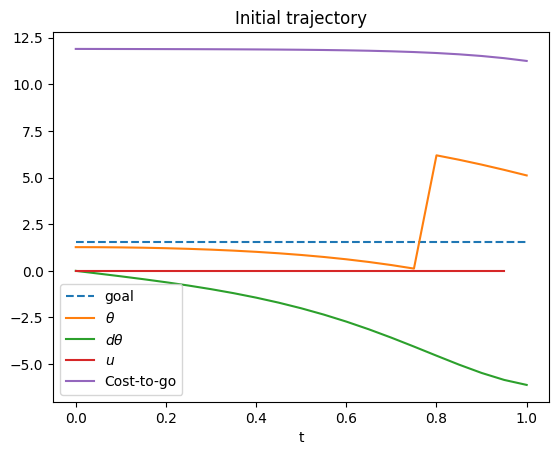

In [1]:
# Code for iLQR applied to a pendulum swing-up problem
%matplotlib inline
import matplotlib.pyplot as plt
from rsbook_code.control.examples.pendulum import Pendulum
from rsbook_code.control.objective import QuadraticObjectiveFunction
from rsbook_code.control.ilqr import iLQR
from rsbook_code.control.optimalcontrol import rollout_policy
from klampt.math import so2
import numpy as np

problem = Pendulum()
#Time step is 0.1
dt = 0.05
#20 time steps
N = 20
#number of state / control dimensions
n, m = 2, 1
#Start state is somewhat up
x0 = np.array([np.pi/2-0.3,0])
u0 = np.zeros(1)

#Objective function measures squared angular deviation from vertical + small squared effort penalty
P = np.zeros((2,2))
P[0,0] = dt
Q = np.zeros((1,1))
Q[0,0] = 0.01*dt
R = np.diag([3,0])
goal = np.array([np.pi/2,0])

class PendulumObjectiveFunction(QuadraticObjectiveFunction):
    """A quadratic function that takes care of the Pendulum's wrapping around 0"""
    def __init__(self,P,Q,R,goal=None):
        QuadraticObjectiveFunction.__init__(self,P,Q,R,goal)
        self._goal = self.goal
        self.goal = np.zeros(self.goal.size)
    def _xdiff(self,x):
        x = np.array(x)
        x[0] = so2.diff(x[0],self._goal[0])
        x[1] = x[1]-self._goal[1]
        return x
    def incremental(self,x,u=None):
        return QuadraticObjectiveFunction.incremental(self,self._xdiff(x),u)    
    def incremental_gradient(self,x,u):
        return QuadraticObjectiveFunction.incremental_gradient(self,self._xdiff(x),u)  
    def incremental_hessian(self,x,u):
        return QuadraticObjectiveFunction.incremental_hessian(self,self._xdiff(x),u) 
    def terminal(self,x):
        return QuadraticObjectiveFunction.terminal(self,self._xdiff(x)) 
    def terminal_gradient(self,x):
        return QuadraticObjectiveFunction.terminal_gradient(self,self._xdiff(x)) 
    def terminal_hessian(self,x):
        return QuadraticObjectiveFunction.terminal_hessian(self,self._xdiff(x)) 
    
objective = PendulumObjectiveFunction(P,Q,R,goal)
objective.checkDerivatives(x0,u0)

#Guessed trajectory: all 0's
us = [u0 for i in range(N)]
xs,us = rollout_policy(problem,x0,us,dt,N)

ilqr = iLQR(problem,objective,dt)
costs = ilqr.evalCosts(xs,us)
ts = np.linspace(0,N*dt,N+1)
plt.plot([0,1],[goal[0],goal[0]],linestyle='--',label='goal')
plt.plot(ts,[x[0] for x in xs],label=r"$\theta$")
plt.plot(ts,[x[1] for x in xs],label=r"$d\theta$")
plt.plot(ts[:-1],[u[0] for u in us],label=r"$u$")
plt.plot(ts,costs,label="Cost-to-go")
plt.title("Initial trajectory")
plt.xlabel('t')
plt.legend()
plt.show()

After running iLQR, the trajectory converges to a path that keeps the pendulum upright.  The terminal cost is nearly 0, so the cost-to-go is low at the end of the trajectory.  But a strong push ($u\approx 5.3$) was necessary for the pendulum to stop falling at the start, which incurs some cost near the start of the trajectory. Nevertheless, the total cost is quite low, less than 1. 

10 iterations of iLQR took 0.03s


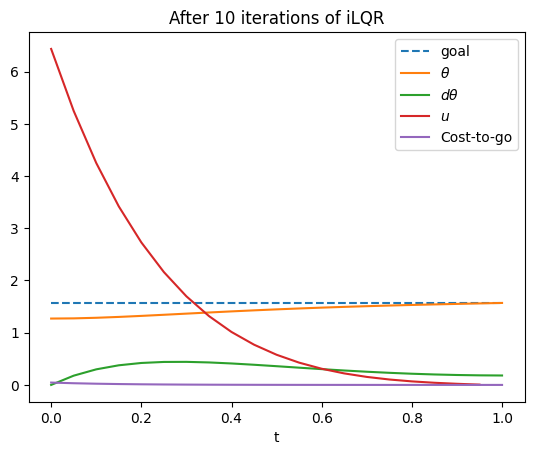

In [2]:
#Running iLQR
import time

t0=time.time()
ilqr.run(xs,us,10)
t1=time.time()
print("10 iterations of iLQR took %.2fs"%(t1-t0))

xs = ilqr.xref
us = ilqr.uref
costs = ilqr.evalCosts(xs,us)
plt.plot([0,1],[goal[0],goal[0]],linestyle='--',label='goal')
plt.plot(ts,[x[0] for x in xs],label=r"$\theta$")
plt.plot(ts,[x[1] for x in xs],label=r"$d\theta$")
plt.plot(ts[:-1],[u[0] for u in us],label=r"$u$")
plt.plot(ts,costs,label="Cost-to-go")
plt.title("After 10 iterations of iLQR")
plt.xlabel('t')
plt.legend()
plt.show()


### Direct transcription 

Direct transcription is related to single shooting but avoids explicitly nested calculations of gradients using the notion of *constrained optimization* ([Appendix C](Optimization.ipynb#Constrained-optimization)).  Constrained optimization
is more complex from the optimization algorithm's point of view, but direct transcription is often far simpler
for an implementer.

The idea is to simply write down the discrete-time optimal control problem and solve it over both $\mathbf{x}$ and $\mathbf{u}$:
\begin{equation}
\begin{gathered}
\mathbf{x}^\star, \mathbf{u}^\star = \arg \min_{\mathbf{x},\mathbf{u}} J(\mathbf{x},\mathbf{u}) = \sum_{i=0}^{N-1} L(x_i,u_i,i) + \Phi(x_N) \text{ such that} \\
x_{1} = g(x_0,u_0) \\
x_{2} = g(x_1,u_1) \\
\vdots \\
x_{N} = g(x_{N-1},u_{N-1})
\end{gathered}
\label{eq:DirectTranscription}
\end{equation}

The added complexity is that the dynamics equations are listed as *equality constraints* which the optimizer must attempt to meet in addition to minimizing the objective function.  Unlike shooting, all of the $x$'s are free variables, and during optimization the $x$'s usually do not meet the dynamics constraints perfectly! 

A helpful way to think of this is to consider the "ideal" predicted state $\hat{x}_i = g(x_{i-1},u_{i-1})$ and the *defect* vector at step $i$: $e_i = x_{i} - \hat{x}_{i}$.  The optimizer will try to simultaneously minimize the value of $J$ while driving all of the defects $e_1,\ldots,e_{N}$ toward 0. As it iterates, the defects will in general be nonzero, meaning that the optimizer will wiggle around a state variable $x_i$ and its corresponding control $u_i$ to simultaneously reduce the running cost $L(x_i,u_i,i)$ while trying to meet $x_i = \hat{x}_i$ and $x_{i+1} = \hat{x}_{i+1} = g(x_i,u_i)$.

By freeing the $x$'s from the $u$'s, direct transcription can often use simpler initialization techniques than shooting. For example, if we wish for the system to reach a goal state, we can initialize the state trajectory to a linear interpolation from the start to the goal and the controls to zero. The initial stages of the optimization will attempt to reconcile the discrepancy between the straight-line guess and the controls by modifying both the states and the controls.

The use of hard constraints in optimization also allows us to specify more versatile constraints. For example, we can easily state that a trajectory should end at a specific goal state, via an equality $x_N=x_G$. Shooting methods cannot in general handle simultaneous goal constraints and nonzero objective functions.  Moreover, if we were to have a constrained optimizer that can accept inequality constraints, we may easily enforce state and control bounds of the form $x_L \leq x_i \leq x_U$ and $u_L \leq u_i \leq u_U$.

Computationally, direct transcription uses many more variables and constraints than shooting.  Including the state variables, we now have $(n+m)N$ optimization variables and an additional $nN$ equality constraints, which has the potential to make optimization slower.  Furthermore, to be efficient when $N$ is large, optimization solvers must accept sparse matrix formulations of constraint jacobians and use sparse linear algebra routines.  

In the below example, we set up a direct transcription formulation of the pendulum trajectory optimization problem.  We bound the control to $|u|\leq 4$, and bound the velocity to $|\dot{\theta}|\leq 10$.  Observe that the initial trajectory has a very low objective function value because we have initialized the state-space trajectory to move directly toward the goal.  However, the defects are relatively high, indicating that this trajectory cannot actually be executed by the initial controls.  After optimizing, the cost is higher, but the defect is now small. 

Note that the example below uses Scipy's minimize() function for compatibility, since many of you will have Scipy installed in your Python environment already (if not, a simple "pip install scipy" should do the trick). Professional-grade trajectory optimizers will use advanced nonlinear solvers like SNOPT and IPOPT that can support sparse matrices. This example also uses manual bookkeeping to pack and unpack the optimization variable (here called "xu" which stacks the x and u variables) and to perform differentiation, but more advanced packages are able to use *automatic differentiation* to set up optimal control problems more conveniently (e.g., [CasADi](https://web.casadi.org/)). 


Initial objective function value: 0.016143750000000005
Initial objective function gradient norm: 0.04017928570793663
Initial defect norm: 0.3957811658104079
Minimization success: True in time 0.03125929832458496 s
Minimized cost 0.056107694579366714
Minimized defect norm: 0.00031560071265448894


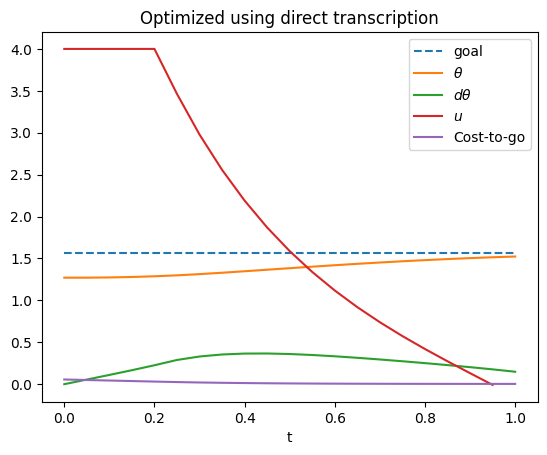

In [3]:
# Direct transcription for the Pendulum example using Scipy's minimize() function

from scipy.optimize import minimize
from scipy import sparse
from rsbook_code.control.dynamics import IntegratorControlSpace

#initial state
x0 = np.array([np.pi/2 - 0.3,0])

#state and control bounds
umin = np.array([-4])
umax = np.array([4])
xmin = np.array([-np.inf,-10])
xmax = np.array([np.inf,10])

#next-state function using Euler integration
g = IntegratorControlSpace(problem,dt,dt)

#indexing
xstart = 0
xend = n*(N+1)
ustart = xend
uend = ustart + m*N
num_dimensions = uend

def J(xu):
    """Objective function reshaped to xu variable"""
    xs = xu[xstart:xend].reshape((N+1,n))
    us = xu[ustart:uend].reshape((N,m))
    return objective.cost(xs,us)
    
def J_gradient(xu):
    """Objective function gradient reshaped to xu variable"""
    xs = xu[xstart:xend].reshape((N+1,n))
    us = xu[ustart:uend].reshape((N,m))
    grad = np.empty(num_dimensions)
    for i in range(N):
        dxi,dui = objective.incremental_gradient(xs[i],us[i])
        grad[xstart+i*n:xstart+(i+1)*n] = dxi
        grad[ustart+i*m:ustart+(i+1)*m] = dui
    dxT = objective.terminal_gradient(xs[N])
    grad[xstart+N*n:xstart+(N+1)*n] = dxT
    return grad

def defects(xu):
    """Dynamics defect vector"""
    xs = xu[xstart:xend].reshape((N+1,n))
    us = xu[ustart:uend].reshape((N,m))
    res = [g.nextState(xs[i],us[i])-xs[i+1] for i in range(N)]
    return np.concatenate(res)

def defects_jacobian(xu):
    """Dynamics defect vector jacobian"""
    xs = xu[xstart:xend].reshape((N+1,n))
    us = xu[ustart:uend].reshape((N,m))
    blocks = [[None for i in range(N+1+N)] for j in range(N)]
    negI = -sparse.eye(n)
    for i in range(N):
        dx,du = g.nextState_jacobian(xs[i],us[i])
        blocks[i][i] = dx
        blocks[i][i+N+1] = du
        if i > 0:
            blocks[i-1][i] = negI
    blocks[N-1][N] = negI
    return sparse.bmat(blocks).todense()
    
xumin = np.concatenate([xmin]*(N+1)+[umin]*N)
xumax = np.concatenate([xmax]*(N+1)+[umax]*N)
constraints = []
constraints.append({'type':'eq','fun':defects,'jac':defects_jacobian})   #defects in dynamics

#set initial state bounds to x0
xumin[xstart:xstart+n] = x0
xumax[xstart:xstart+n] = x0

#initialize trajectory guess with linear interpolation between start and goal
xs = np.zeros((N+1)*n)
xs[::2] = np.interp(np.linspace(0,1,N+1),[0,1],[x0[0],goal[0]])
xs[1::2] = np.interp(np.linspace(0,1,N+1),[0,1],[x0[1],goal[1]])
us = np.zeros(N*m)
xu0 = np.concatenate([xs,us])

print("Initial objective function value:",J(xu0))
print("Initial objective function gradient norm:",np.linalg.norm(J_gradient(xu0)))
print("Initial defect norm:",np.linalg.norm(defects(xu0)))
t0 = time.time()
res = minimize(J,xu0,method='SLSQP',jac=J_gradient,bounds=list(zip(xumin,xumax)),constraints=constraints,tol=1e-2)
t1 = time.time()
xu = res.x
print("Minimization success:",res.success,"in time",t1-t0,"s")
print("Minimized cost",res.fun)
print("Minimized defect norm:",np.linalg.norm(defects(xu)))

#extract trajectory
xs = xu[xstart:xend].reshape((N+1,n))
us = xu[ustart:uend].reshape((N,m))
costs = ilqr.evalCosts(xs,us)
plt.plot([0,1],[goal[0],goal[0]],linestyle='--',label='goal')
plt.plot(ts,[x[0] for x in xs],label=r"$\theta$")
plt.plot(ts,[x[1] for x in xs],label=r"$d\theta$")
plt.plot(ts[:-1],[u[0] for u in us],label=r"$u$")
plt.plot(ts,costs,label="Cost-to-go")
plt.title("Optimized using direct transcription")
plt.xlabel('t')
plt.legend()
plt.show()

### Pseudospectral / collocation methods

As an alternative to piecewise constant controls, it is also possible to
use other discretizations, such as [polynomials or splines](WhatIsMotionPlanning.ipynb#Representations-of-paths). In any case,
the control is specified by a linear combination of *basis functions*
$$u(t) = \sum_{i=1}^k c_i \beta_i(t)$$ where the $c_i \in \mathbb{R}^m$
are control coefficients, which are to be chosen by the optimization,
and the basis functions $\beta_i(t)$ are constant. For example, a set of
polynomial basis functions could be $1$, $t$, $t^2$, \..., $t^{k-1}$.
The difficulty with such parameterizations is that the state trajectory
depends on every control coefficient, so evaluating the gradient is
computationally expensive. 

To address this problem, it is typical to include a *state trajectory parameterization* in
which the state trajectory $x(t)$ is also represented as an optimization variable that is
parameterized explicitly along with the control trajectory. Specifically, we suppose that $$x(t) = \sum_{i=1}^k d_i \gamma_i(t)$$ where the $d_i \in \mathbb{R}^n$ are state coefficients to be optimized, and the basis functions $\gamma_i$ are constant functions of time.

TODO: illustration (Figure 6)

The main challenge is then to enforce dynamic consistency between the $x$ trajectory and the $u$ trajectory over the time domain.  Because it is impossible to do this exactly in a continuous infinity of points, the dynamic consistance must then be enforced at a finite number of points
in time, which are known as *collocation points*. The result is an
equality-constrained, finite-dimensional optimization problem.

Specifically, given $N$ points in the time domain $t_1,\ldots,t_N$, dynamic consistency is enforced at the $j$'th time point with a constraint
$$
x^\prime(t_j) = f(x(t_j),u(t_j) )
$$
which can be rewritten in terms of the cofficients
$$
\sum_{i=1}^k d_i \gamma_i^\prime(t_j) = f\left(\sum_{i=1}^k d_i \gamma_i(t_j), \sum_{i=1}^k c_i \beta_i(t_j) \right).
$$


### Indirect methods

Indirect methods are an alternative numerical method that avoids explicit discretization of the
control trajectory, and instead uses Pointryagin's minimum principle to reduce the search space
considerably. By PMP condition 3, we see that the state and costate variables $(x,\lambda)$ for an optimal
trajectory evolve according to the ordinary differential equations (ODEs)
$$\dot{x}(t) = f(x(t),u^\star(t)),$$
$$\dot{\lambda}(t) = -\frac{\partial}{\partial x}H(\lambda(t),x(t),u^\star(t),t).$$

Supposing that we could analytically or efficiently solve for the optimal control at each time $t$ knowing $x(t)$ and $\lambda(t)$,
$$u^\star(t) \equiv \arg \min_{u\in \mathcal{U}} H(\lambda(t),x(t),u,t)$$
then we can treat $d/dt (x,\lambda)$ as an ODE.  Then, if we were to know $\lambda(0)$, then the
state and costate trajectories could be determined through standard integration techniques.  

However, we do not precisely know what $\lambda(0)$ actually is.  But the optimal trajectory is
defined by *some* initial value of $\lambda$.  In other words, we can reduce the search over optimal trajectories
to a search over an $n$-D variable!  This is the general idea behind shooting methods.  They proceed as follows

Repeat until convergence:

1. Guess a value of $\lambda_0 \in \mathbb{R}^n$.
2. Integrate $(x,\lambda)$ according to the ODE defined by PMP 2 and 3 from the initial condition $(x_0, \lambda_0)$.  In the ODE, PMP 1 is used to derive $u^\star(t)$ at each time step.  Let the resulting trajectories be denoted $(x(\cdot;\lambda_0),\lambda(\cdot;\lambda_0))$
3. Assess the value of the objective functional $J(x(\cdot;\lambda_0),\lambda(\cdot;\lambda_0))$
4. Compute the gradient of $J$ w.r.t. $\lambda_0$, $\nabla_{\lambda_0} J$.
5. Take a gradient step in the direction of $-\nabla {\lambda_0} J$.

As in direct transcription, calculating the gradient is the most cumbersome part (Step 4).  Supposing
that we are using Euler integration with integration time step $h$, and we can derive $\nabla_{x(t)} u^\star(t)$. $\nabla_{\lambda(t)} u^\star(t)$. Then 
$$\lambda(t+h) = \lambda(t) - h \frac{\partial}{\partial x}H(\lambda(t),x(t),u^\star(t),t) $$
$$x(t+h) = x(t) + h f(x(t),u^\star(t)).$$

Applying the chain rule, we obtain recursive equations for $\nabla_{\lambda_0} u^\star(t)$, $\nabla_{\lambda_0} x(t)$, and $\nabla_{\lambda_0} \lambda(t)$:

$$\nabla_{\lambda_0} u^\star(t) = \nabla_{x(t)} u^\star(t) \nabla_{\lambda_0} x(t) + \nabla_{\lambda(t)} u^\star(t) \nabla_{\lambda_0} \lambda(t)$$

$$\nabla_{\lambda_0} x(t+h) = \nabla_{\lambda_0} x(t) + h \nabla_x f(x(t),u^\star(t)) \nabla_{\lambda_0} x(t)  + h \nabla_u f(x(t),u^\star(t)) \nabla_{\lambda_0} u^\star(t)$$

$$\nabla_{\lambda_0} \lambda(t+h) = \nabla_{\lambda_0} \lambda(t) - h \frac{\partial^2}{\partial x^2}H(\lambda(t),x(t),u^\star(t),t) \nabla_{\lambda_0} x(t)  - h \frac{\partial^2}{\partial x \partial \lambda}H(\lambda(t),x(t),u^\star(t),t) \nabla_{\lambda_0} \lambda(t) - h \frac{\partial^2}{\partial x \partial u}H(\lambda(t),x(t),u^\star(t),t) \nabla_{\lambda_0} u^\star(t)$$

Observe that evaluating this latter recursive step requires $L$ and $f$ to be twice differentiable, and we also required the derivative of the optimal control with respect to state and costate. 
It should also be noted that the potential landscape of $J$ as a function of $\lambda_0$ is extremely
complex and fraught with local minima, and the domain of $\lambda_0$ is unbounded with optimal
values that can have extremely large magnitudes.  So, guessing an appropriate value of $\lambda_0$ that
lies within the basin of attraction of the optimum can be difficult. 
These requirements can make it challenging to apply shooting methods in practice.


### Local minima

A major issue with any descent-based trajectory optimization approach is
local minima. As an example, suppose we initialize the iLQR example above with an
guessed trajectory in which the pendulum falls freely and swings over to the left
(here the trajectory is simulated  from the initial state (0.9,0) with 0 controls).
The final state of this trajectory is closer to the goal on the left while the
initial state is on the right, swinging through the downward position. 

Here, iLQR is not able to recover to the alternative which keeps the pendulum upright. However, 
it is able to find a trajectory with a final state that is close to upright, reducing the overall
cost. It achieves this state by moving *more aggressively* through the downward state ($3\pi/2 \approx 4.7$)!

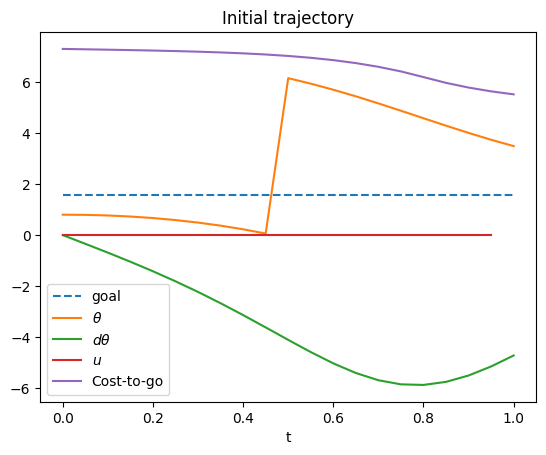

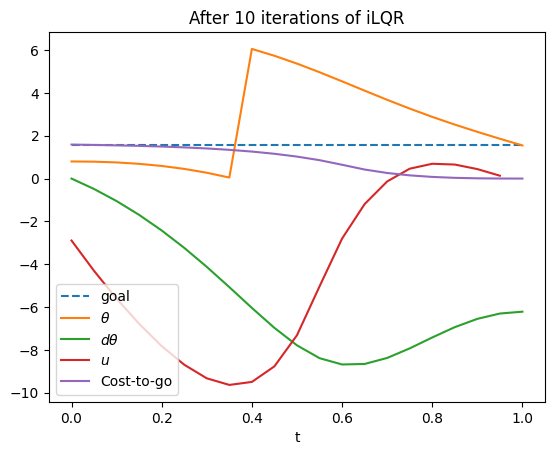

In [4]:
# iLQR falling into a local minimum
x0 = np.array([0.8,0])
us = [u0 for i in range(N)]
xs,us = rollout_policy(problem,x0,us,dt,N)

ilqr = iLQR(problem,objective,dt)
costs = ilqr.evalCosts(xs,us)
ts = np.linspace(0,N*dt,N+1)
plt.plot([0,1],[goal[0],goal[0]],linestyle='--',label='goal')
plt.plot(ts,[x[0] for x in xs],label=r"$\theta$")
plt.plot(ts,[x[1] for x in xs],label=r"$d\theta$")
plt.plot(ts[:-1],[u[0] for u in us],label=r"$u$")
plt.plot(ts,costs,label="Cost-to-go")
plt.title("Initial trajectory")
plt.xlabel('t')
plt.legend()
plt.show()

ilqr.run(xs,us,10)

xs = ilqr.xref
us = ilqr.uref
costs = ilqr.evalCosts(xs,us)
plt.plot([0,1],[goal[0],goal[0]],linestyle='--',label='goal')
plt.plot(ts,[x[0] for x in xs],label=r"$\theta$")
plt.plot(ts,[x[1] for x in xs],label=r"$d\theta$")
plt.plot(ts[:-1],[u[0] for u in us],label=r"$u$")
plt.plot(ts,costs,label="Cost-to-go")
plt.title("After 10 iterations of iLQR")
plt.xlabel('t')
plt.legend()
plt.show()

Local minima are very common in trajectory optimization due to the high dimensionality and
nonlinearity of these optimization problems. Only in a few cases can we prove that the problem is
convex, such as in LTI problems with convex costs and linear control
constraints.

As we have seen before, random restarts are one of the most
effective ways to handle local minima, but trajectory optimization takes place
in a very high dimensional space. Due to the high dimensionality of the parameter space,
a prohibitive number of restarts is needed if we want to have a high chance of finding a
global optimum.  Hence, for a robot to perform trajectory optimization reliably, a considerable amount of
effort needs to be spent finding good initializers or engineering the cost landscape
such that it has few local minima.

### Methods for handling obstacles and constraints

To meet constraints and avoid obstacles in trajectory optimization there are several formulations, each with their strengths and weaknesses. 

1. Formulate as unconstrained optimization, using *barrier functions* penalizing proximity to constraints.
2. Formulate as inequality constraints, ensuring nonnegative distance to constraints.
3. Formulate as pointwise inequality constraints, then solve a sequence of optimizations in which points are incrementally added (semi-infinite programming).

#### Barrier function methods

In the barrier function formulation, we assume that for each constraint $C$ a continuous (and ideally smooth) function $d_C(x)$ that measures the distance from a state $x$ to violating the constraint.  To ensure smoothness when penetrating the constraint this should be a *signed* distance in which $d_C(x) < 0$ in the penetrating case, $d_C(x)=0$ when $x$ is just on the boundary of the constraint, and $d_C(x) > 0$ when $x$ is collision and contact-free.  Ideally, the gradient of $d_C$ should be oriented to push $x$ away from constraint violation.

To use barrier functions, we define some barrier function $\rho(d)$ that increases as $d$ shrinks, and decreases as $d$ grows large. For example, some popular barrier functions are defined as follows:

- Log-barrier: $\rho(d) \propto -\log d$.  Hard, $C_\infty$ for $d>0$.
- Inverse: $\rho(d) \propto 1/d - 2/d_{max}+d/d_{max}^2$ if $0 < d < d_{max}$, 0 if $d \geq d_{max}$, and $\infty$ if $d<0$.  Hard, $C_1$ for $d>0$, 0 for $d > d_{max}$.
- Half-quadratic: $\rho(d) \propto \max(0,(d_{max}-d)^2)$.  Soft, $C_1$, 0 for $d > d_{max}$.

![Barrier function illustration](figures/control/barrier-functions.png)

We then can optimize the barrier-augmented objective functional $\tilde{J}(\mathbf{x},\mathbf{u}) = J(\mathbf{x},\mathbf{u}) + \alpha \sum_i \sum_C \rho(d_C(x_i))$ in which $\alpha > 0$ is a term that weighs between constraint avoidance and objective minimization.

Hard barrier functions go to infinity as $d\rightarrow 0$, which prevents constraint violations entirely at an optimal solution to the barrier-augmented optimization problem. Soft barrier functions do not, and instead require sufficiently high values of $\alpha$ to prevent constraint violations.  The main disadvantage of hard barrier functions is that if at any point the trajectory in the optimizer violates a constraint, then it will be unable to make further progress.  This requires carefully choosing the initial guess for optimization and also designing appropriate line search methods to avoid violating constraints. Moreover, the derivatives of hard barrier functions get less numerically stable as $d\rightarrow 0$.

#### Inequality constraint methods

Inequality constraint methods also assume the existence of a distance function $d_C(x)$, and simply use constrained optimization techniques like direct transcription to enforce constraint satisfaction in the optimizer:
\begin{equation}
\begin{gathered}
\mathbf{x}^\star, \mathbf{u}^\star = \arg \min_{\mathbf{x},\mathbf{u}} J(\mathbf{x},\mathbf{u}) \text{ such that} \\
x_{i+1} = g(x_i,u_i) \text{ for }i=0,\ldots,N-1 \\
x_L \leq x_{i} \leq x_U \text{ for }i=1,\ldots,N \\
u_L \leq u_{i} \leq u_U \text{ for }i=0,\ldots,N-1 \\
d_C(x_i) \geq 0 \text{ for }i=1,\ldots,N \text{ and all constraints }C 
\end{gathered}
\label{eq:DirectTranscriptionObstacles}
\end{equation}
Such a problem formulation can more stable than barrier function methods, although constrained optimizers are typically more expensive than unconstrained ones. 


#### Example: Double integrator with obstacle
The below example is a 2D double integrator problem with state $x=(p_x,p_y,v_x,v_y)$, control $u=(u_x,u_y)$, dynamics

$$
\begin{bmatrix}
\dot{p_x} \\
\dot{p_y} \\
\dot{v_x} \\
\dot{v_y} \\
\end{bmatrix} = 
\begin{bmatrix}
\dot{v_x} \\
\dot{v_y} \\
\dot{u_x} \\
\dot{u_y} \\
\end{bmatrix}
$$

and a cost function with goal-attraction, effort, and obstacle penalty terms. The incremental cost uses a standard quadratic objective plus a barrier term for obstacle avoidance:
$$L(x,u) = (p_x-g_x)^2 + (p_y-g_y)^2 + 0.01(u_x^2+u_y^2) + \frac{1}{10\Delta t}\rho(d(x))$$
and the terminal cost is 
$$\Phi(x) = 10(p_x-g_x)^2 + 10(p_y-g_y)^2 + v_x^2 + v_y^2 + \frac{1}{10}\rho(d(x)).$$
In the below implementation, the log barrier function is used. Note that since a log barrier is a hard constraint, we require that the entire initial trajectory to strictly obey the constraint. 

The obstacle here is a simple circle constraint $\|(p_x - c_x)^2 + (p_y - c_y)^2\| \geq r$ with $(c_x,c_y)$ the circle center and $r$ the radius.  It is implemented as the signed distance function $d(x) = \|(p_x - c_x)^2 + (p_y - c_y)^2\| - r$.

Without a penalty term, the optimal path would pass right through the obstacle.  After optimization with the penalty term, the trajectory circumvents the obstacle to reach toward the goal.

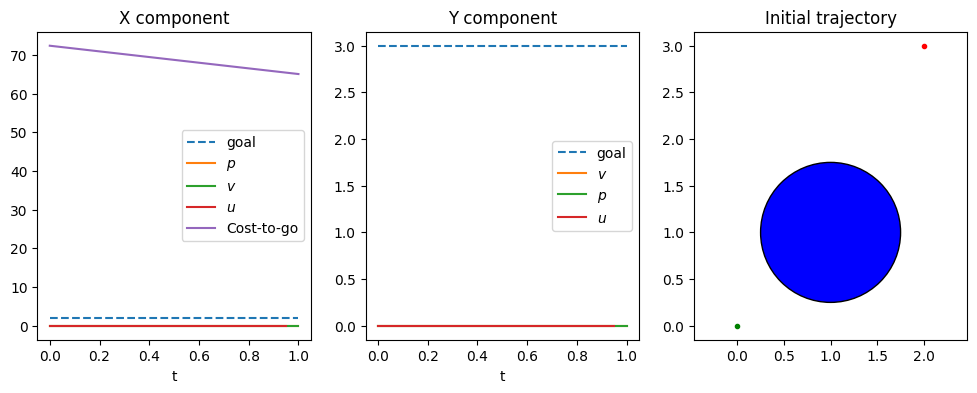

In [5]:
# Code for barrier functions + inequality constraint formulations of obstacle avoidance
%matplotlib inline
from rsbook_code.control.examples.doubleintegrator import DoubleIntegrator
from rsbook_code.control.barrier import BarrierPenalty
from matplotlib import patches

problem = DoubleIntegrator(2)
barrier_strength = 0.1

#Time step is 0.1
dt = 0.05
#20 time steps
N = 20
#number of state / control dimensions
n, m = 4, 2
#Start state is 0
x0 = np.array([0.0]*4)
u0 = np.zeros(2)
#infeasible initial control
#u0 = np.array([2.0,3.0])

#Objective function measures distance to goal + small squared effort penalty + some penalty on final time
P = np.zeros((4,4))
P[0,0] = dt
P[1,1] = dt
Q = np.eye(2)*0.01*dt
R = np.diag([10,10,1,1])
goal = np.array([2,3,0,0])

class CircleObstacle:
    def __init__(self,center,radius):
        self.center = center
        self.radius = radius
    def distance(self,x):
        return np.linalg.norm(x[:len(self.center)]-self.center) - self.radius
    def distance_gradient(self,x):
        g = np.zeros(len(x))
        n = len(self.center)
        dx = (x[:n] - self.center)
        d = np.linalg.norm(dx)
        g[:n] = dx/d
        return g
    def plot(self,ax):
        ax.add_artist(patches.Circle(self.center,self.radius,ec='k',color='blue'))
        
obstacle = CircleObstacle(center=(1,1),radius=0.75)
#valid barrier types include 'log', 'inv', and 'quadratic'
barrier = BarrierPenalty(obstacle.distance,obstacle.distance_gradient,barriertype='log')
objective = QuadraticObjectiveFunction(P,Q,R,goal) + barrier*barrier_strength

#Guessed trajectory: all 0's
us = [u0 for i in range(N)]
xs,us = rollout_policy(problem,x0,us,dt,N)

def plot_double_integrator(xs,us,goal,costs,ax1,ax2):
    ax1.set_title('X component')
    ax1.plot([0,1],[goal[0],goal[0]],linestyle='--',label='goal')
    ax1.plot(ts,[x[0] for x in xs],label=r"$p$")
    ax1.plot(ts,[x[2] for x in xs],label=r"$v$")
    ax1.plot(ts[:-1],[u[0] for u in us],label=r"$u$")
    if costs is not None:
        ax1.plot(ts,costs,label="Cost-to-go")
    ax1.set_xlabel('t')
    ax1.legend()

    ax2.set_title('Y component')
    ax2.plot([0,1],[goal[1],goal[1]],linestyle='--',label='goal')
    ax2.plot(ts,[x[3] for x in xs],label=r"$v$")
    ax2.plot(ts,[x[1] for x in xs],label=r"$p$")
    ax2.plot(ts[:-1],[u[1] for u in us],label=r"$u$")
    ax2.set_xlabel('t')
    ax2.legend()

def vis_double_integrator(xs,us,goal,obstacles,ax):
    for obs in obstacles:
        obs.plot(ax)
    ax.plot([x[0] for x in xs],[x[1] for x in xs])
    ax.scatter([xs[0][0]],[xs[0][1]],s=9,c='g')
    ax.scatter([goal[0]],[goal[1]],s=9,c='r')
    ax.axis('equal')

ilqr = iLQR(problem,objective,dt)
costs = ilqr.evalCosts(xs,us)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
plot_double_integrator(xs,us,goal,costs,ax1,ax2)
ax3.set_title("Initial trajectory")
vis_double_integrator(xs,us,goal,[obstacle],ax3)
plt.show()

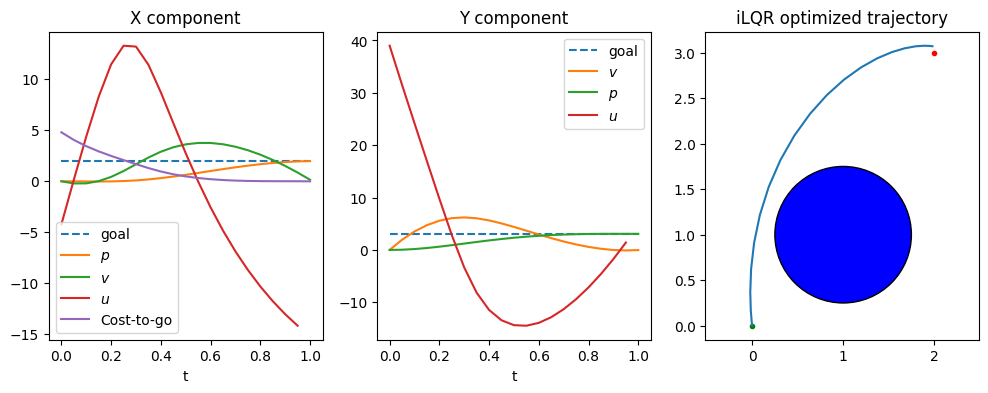

In [6]:
# Code for barrier functions + inequality constraint formulations of obstacle avoidance    

result = ilqr.run(xs,us,20,damping=1e-3)
xs = ilqr.xref
us = ilqr.uref

costs = ilqr.evalCosts(xs,us)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

plot_double_integrator(xs,us,goal,costs,ax1,ax2)
ax3.set_title("iLQR optimized trajectory")
vis_double_integrator(xs,us,goal,[obstacle],ax3)
plt.show()

### Handling infinite-horizon problems

There are some challenges when applying trajectory optimization to
infinite-horizon optimal control problems. Specifically, it is not
possible to define a computational grid over the infinite domain
$[0,\infty)$ for the purposes of computing the integral in $J(x,u)$. To
do so, there are two general techniques available. The first is to
simply truncate the problem at some maximum time $T$, leading to a
finite-horizon optimal control problem.

The second method is to reparameterize time so that the range
$[0,\infty)$ is transformed into a finite range, say $[0,1]$. If we let
$s=1-e^t$ then $s$ is in the range $[0,1]$. The cost functional then
becomes:
$$J(x,u) = \int_0^1 L(x(-\ln(1-s)),u(-\ln(1-s)),-\ln(1-s)) / (1-s) ds.$$
This leads to a finite-horizon optimal control problem over the $s$
domain, with $T=1$. Hence, if a uniform grid is defined over
$s \in [0,1]$, then the grid spacing in the time domain becomes
progressively large as $t$ increases.

In the reformulated problem it is necessary to express the derivative of
$x$ with respect to $s$ in the new dynamics:
$$\frac{d}{d s} x(t(s)) = \dot{x}(t(s)) t^\prime(s) = f(x(t(s)),u(t(s))) / (1-s)$$
Care must also be taken as $s$ approaches 1, since the $1/(1-s)$ term
approaches infinity, and if instantaneous cost does not also approach 0,
then cost will become infinite. It is therefore customary to use a
discount factor. With an appropriately defined discount term, the $s=1$
contribution to cost will be dropped.


Hamilton-Jacobi-Bellman Equation
--------------------------------

An alternative method to solve optimal control problems is to find the
solution in *state space* rather than the time domain. In the
Hamilton-Jacobi-Bellman (HJB) equation, so named as an extension of the
Bellman equation for discrete optimal planning problems, a partial
differential equation (PDE) across state space is formulated to
determine the optimal control everywhere. (Contrast this with the
Pointryagin's minimum principle, which is an optimality condition only
along a single trajectory.)

### Derivation

We start by formulating the HJB equation in discrete time. Consider a
finite-horizon optimal control problem, and define the *value function*
as a function
$V(x,t) : \mathbb{R}^n \times \mathbb{R} \rightarrow \mathbb{R}$ that defines the
*minimum possible accumulated cost* that could be obtained by any trajectory
starting from initial state $x$ and time $t$.  In other words, let us define the
truncated cost functional
\begin{equation}
J_t(x,u) = \int_t^T L(x,u,s) ds + \Phi(x(T))
\end{equation}
which truncates the lower point in the integral term of $J(x,u)$ to start from time
$t$. (Obviously, $J(x,u)=J_0(x,u)$.)  Then, the value function is the minimizer of
the truncated cost over all possible future controls: $V(x,t) = \min_u(J_t(x,u))$.
The value is also known as the *cost to go*, measuring the remaining cost to reach
a goal. (This stands in contrast to the *cost to come* which is the cost that would be
accumulated to reach a state $x$ from the start.)

TODO: illustration (Figure 7)

It is apparent that at time $T$, the only term that remains is the
terminal cost, so one boundary term is given: $$V(x,T) = \Phi(x).$$ Now
we examine the value function going backwards in time. Suppose we know
$V(x,t+\Delta t)$ for all $x$, and now we are considering time $t$. Let
us also assume that at a state $x$ with control $u$, the resulting state
at time $T$ is approximated by Euler integration, and the incremental
cost is approximately constant over the interval $[t,t+\Delta t)$. Then,
we have the approximation
\begin{equation}
V(x,t) \approx \min_{u\in U} [ \Delta t L(x,u,t) + V(x + \Delta t f(x,u),t+\Delta t)]
\label{eq:DiscreteTimeHJB}
\end{equation}
The minimization is taken over controls to
find the optimal control for the next time step. The first term of the
minimized term includes the incremental cost from the current state,
time, and chosen control. The second term includes the cost contribution
from the next state under the chosen control, incremented forward in
time.

Note that the first order approximation of $V(x,t)$ is given by:
\begin{equation}
V(x+\Delta x,t+\Delta t) \approx V(x,t) + \frac{\partial V}{\partial x}(x,t) \Delta x + \dot{V}(x,t)\Delta t
\end{equation}
If we take the limit of
($\ref{eq:DiscreteTimeHJB}$) as the time step $\Delta t$ approaches
0, subtract $V(x,t)$ from both sides, and divide by $\Delta t$, then we
obtain the Hamilton-Jacobi-Bellman PDE :
\begin{equation}
0 = \dot{V}(x,t) + \min_{u \in U} [ L(x,u,t) + \frac{\partial V}{\partial x}(x,t) f(x,u)].
\label{eq:HJB}
\end{equation}

If these equations were to be solved either in discrete or continuous
time across the $\mathbb{R}^n \times \mathbb{R}$ state space, then we
have a complete description of optimal cost starting from any state. It
is also possible to enforce state constraints simply by setting the
value function at inadmissible states to $\infty$. Moreover, it is a
relatively straightforward process to determine the optimal control
given a value function:
\begin{equation}
u^\star(x,t) = \arg \min_{u \in U} [ \Delta t L(x,u,t) + V(x + \Delta t f(x,u),t + \Delta t)]
\end{equation}
for the discrete case and
\begin{equation}
u^\star(x,t) = \arg \min_{u \in U} [ L(x,u,t) + \frac{\partial V}{\partial x}(x,t) f(x,u)]
\end{equation}
for the continuous case. The main challenge here is to represent and
calculate a function over an $n+1$ dimensional grid, which is
prohibitively expensive for high-D state spaces. It is also potentially
difficult to perform the minimization over the control
in ($\ref{eq:DiscreteTimeHJB}$)
and ($\ref{eq:HJB}$),
since it must be performed at each point in time and space.

### Reducing dimension by 1 using time-independence

It is often useful to reduce the dimensionality down to an $n$-D grid if
the incremental cost is time-independent and the problem has an infinite
horizon. With these assumptions, the optimal control is *stationary*,
that is, it is dependent only on state and not time. Then, we can set up
a set of recursive equations on a time-independent value function:

\begin{equation}
V(x) = \min_{u \in U} [ \Delta L(x,u) + V(x+\Delta t f(x,u)) ]
\label{eq:DiscreteHJBStationary}
\end{equation}

in the discrete time case, or taking
the limit as $\Delta t \rightarrow 0$, we get the continuous PDE

\begin{equation}
0 = \min_{u \in U} [ L(x,u) + \frac{\partial V}{\partial x}(x) f(x,u) ].
\end{equation}


### Solution methods

It can be rather challenging to solve either the time-dependent or the
stationary equations exactly due the dimensionality of the grids used,
and the recursive nature of the stationary equations. Also, some
discretization of the control set $U$ is usually needed, and a
finer discretization will help the method
compute better estimates. Three general methods exist for solving HJB
equations:

1.  Value iteration uses a guess of $V(x)$ and then iteratively improves
    it by optimizing
    ($\ref{eq:DiscreteHJBStationary}$) on each $x$ in the grid. This
    is also known as recursive dynamic programming and is a continuous-space variant of the
    value iteration algorithm discussed in [Chapter 11](PlanningWithDynamicsAndUncertainty.ipynb#Value-iteration).

2.  Policy iteration assigns guesses for the policy $u(x)$, and
    iteratively alternates between a) solving for the $V(x)$ induced by
    those controls, and b) improving the assigned controls using the
    induced $V(x)$.  This is a continuous-space  variant of the
    policy iteration algorithm discussed in [Chapter 11](PlanningWithDynamicsAndUncertainty.ipynb#Policy-iteration).

3.  Linear programming uses a set of sample points $x_1,\ldots,x_N$ on a
    state space grid and points $u_1,\ldots,u_M$ on a control space
    grid, and then sets up a large linear programming problem with
    constraints of the form
    ($\ref{eq:DiscreteHJBStationary}$).

4.  The Fast Marching Method can be thought of as a one-pass value iteration, which is
    applicable to problems with known terminal sets and positive costs.  The principle is similar to
    the "brush fire" method for calculating navigation functions as discussed in
    [Chapter 11](PlanningWithDynamicsAndUncertainty.ipynb#Navigation-functions-and-the-Dynamic-Window-Approach). 
    Observe that once a value is defined for the goal states, their value no
    longer needs to be updated; they are called *closed*.  We can try to
    determine all states for which the value is below some threshold $v$, and these
    states will be found in a small neighborhood of the closed states, known as the *frontier*.
    Once these states' values are determined, they are added to the closed states, and a new set of
    frontier states is determined.  Next, we increase $v$ and repeat the process, until all
    states are visited.


Start state [4.71238898 0.        ] goal state [1.57079633 0.        ]


#### HJB Solver

<IPython.core.display.Javascript object>


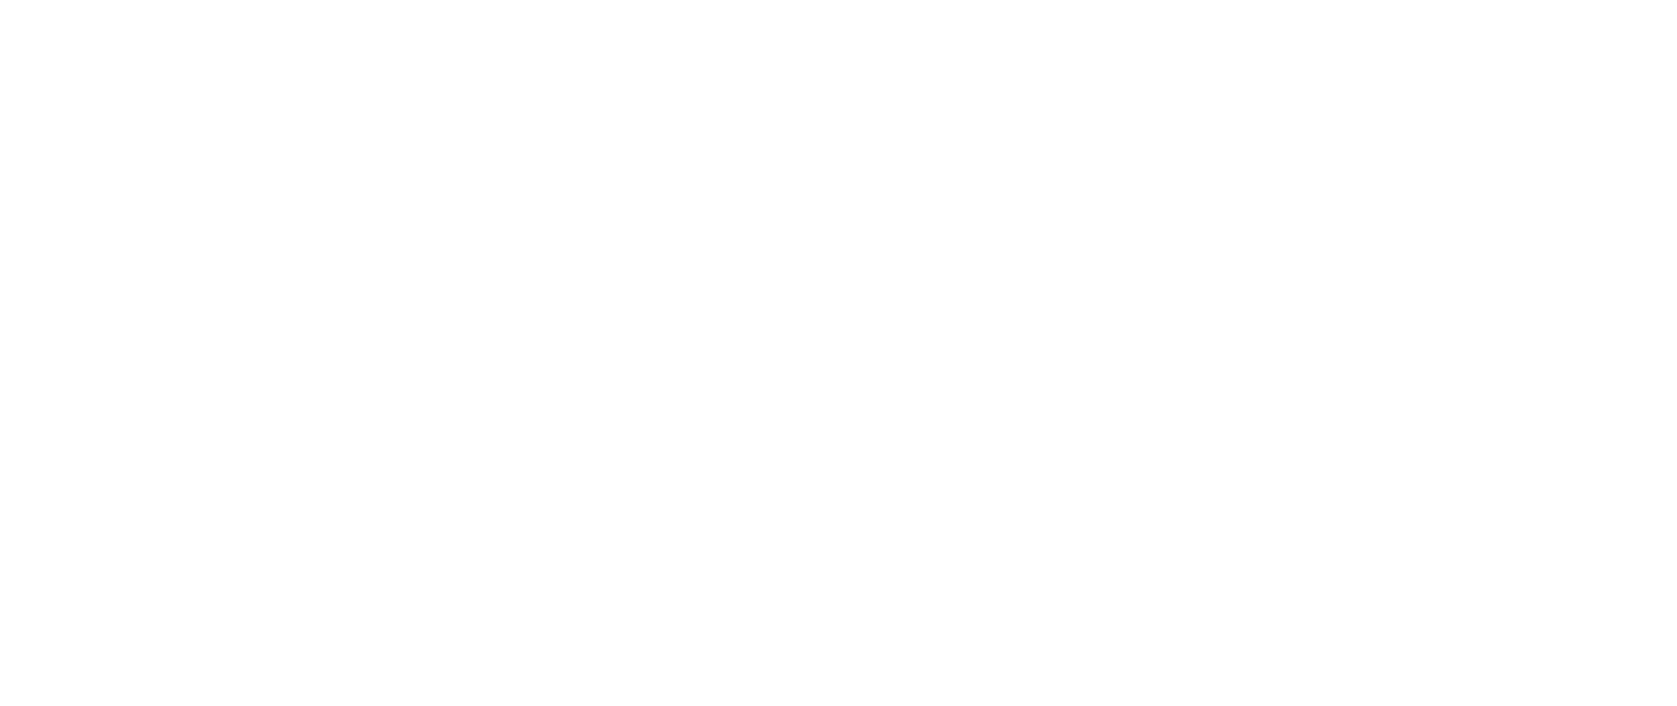

interactive(children=(IntSlider(value=11, description='i', max=101, min=1, step=10), Button(description='Run I…

In [7]:
#Code for a pendulum HJB problem
from rsbook_code.control.examples.pendulum import Pendulum
from rsbook_code.control.optimalcontrol import OptimalControlProblem,ControlSampler,rollout_policy,LookaheadPolicy
from rsbook_code.control.objective import ObjectiveFunction
from rsbook_code.control.hjb import HJBSolver,OptimalControlTreeSolver
from rsbook_code.control.dynamics import simulate
import numpy as np
import math
%matplotlib notebook

#this is needed to sample from the control space
class PendulumControlSampler(ControlSampler):
    def __init__(self,umin,umax):
        self.umin = umin
        self.umax = umax
    def sample(self,state):
        return [[self.umin],[0],[self.umax]]
    
class TimeObjectiveFunction(ObjectiveFunction):
    def __init__(self,dt):
        self.dt = dt
    def incremental(self,state,control):
        return abs(self.dt)
    
class EffortObjectiveFunction(ObjectiveFunction):
    def __init__(self,dt):
        self.dt = dt
    def incremental(self,state,control):
        return np.linalg.norm(control)**2*self.dt

#create the dynamics function, terminal conditions, and control bounds
dynamics = Pendulum()
umin = -2.5
umax = 2.5
down = np.array([math.pi*3/2,0])
right = np.array([0,0])
up = np.array([math.pi/2,0])
start = down
goal = up
bounds = [(0,math.pi*2),(-6,6)]
controlSampler = PendulumControlSampler(umin,umax)
#need to set dt large enough to have a chance to jump cells
dt = 0.1
objective = TimeObjectiveFunction(dt)
problem = OptimalControlProblem(start,dynamics,objective,goal=goal,controlSampler=controlSampler,dt=dt)

grid_resolution = (50,60)
hjb = HJBSolver(problem,bounds,grid_resolution)
scell = hjb.stateToCell(problem.x0)
print("Start state",start,"goal state",goal)
#print("Start cell",scell)
#print("Start cell center state",hjb.cellToCenterState(scell))
#print("Goal cell",hjb.stateToCell(problem.goal))

from rsbook_code.control.hjb import GridCostFunctionDisplay
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display,Markdown
import matplotlib.pyplot as plt
%matplotlib notebook

display(Markdown("#### HJB Solver"))
hjbdisplay = GridCostFunctionDisplay(hjb,hjb.value,hjb.policy,policyDims=1,figsize=(9.5,4))
hjbdisplay.show()

def do_value_iteration(i):
    print("Running",i,"value iteration steps")
    hjb.valueIteration(iters=i)
    hjbdisplay.refresh(hjb.value,hjb.policy)
    if hjb.getPolicy(start) is not None:
        #show the HJB policy 
        xs,us = rollout_policy(dynamics,start,(lambda x:hjb.getPolicy(x)),dt*0.5,200)
        hjbdisplay.plotTrajectory(xs,color='r',zorder=3)
        
        la_policy = LookaheadPolicy(problem,hjb.interpolateValue,goal=(lambda x:False))
        xs,us = rollout_policy(dynamics,start,la_policy,dt,200)
        hjbdisplay.plotTrajectory(xs,color='y',zorder=4)
    hjbdisplay.plotFlow(lambda x:hjb.getPolicy(x),color='k',linewidth=0.5)
interact_manual(do_value_iteration,i=widgets.IntSlider(min=1, max=101, step=10, value=11));


#### Forward Solver

<IPython.core.display.Javascript object>


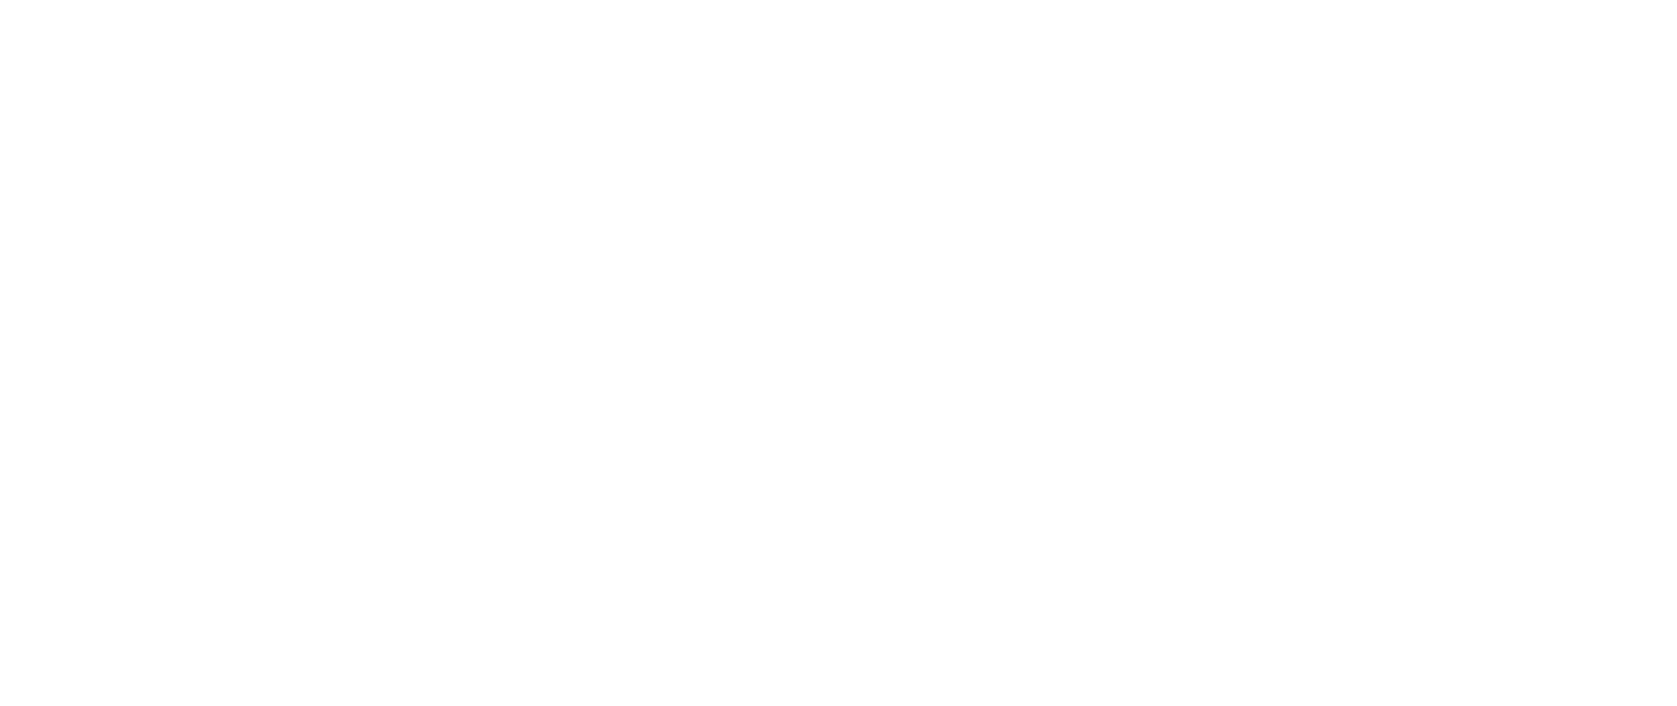

interactive(children=(IntSlider(value=1001, description='N', max=10001, min=1, step=100), Button(description='…

In [8]:
#this does forward search
%matplotlib notebook

tree = OptimalControlTreeSolver(problem,
                bounds,[50,60])
tree.maxVisitedPerCell = 5

display(Markdown("#### Forward Solver"))
treedisplay = GridCostFunctionDisplay(tree,tree.costToCome(),tree.reversePolicy(),policyDims=1,figsize=(9.5,4))
treedisplay.show()

def do_fw_search(N):
    print("Doing forward search")
    for i in range(N):
        tree.search_step()
    treedisplay.refresh(tree.costToCome(),tree.reversePolicy())

    path = tree.result_path()
    if tree.goal is not None:
        assert len(path) > 0
    if len(path) > 0:
        if len(path[0].state)==0:
            path = path[1:]
        if path[-1].state == None:
            path = path[:-1]
        xs = np.array([n.state for n in path])
        treedisplay.plotTrajectory(xs,color='r',zorder=3)

interact_manual(do_fw_search,N=widgets.IntSlider(min=1, max=10001, step=100, value=1001));


Model Predictive Control
------------------------

The method of model predictive control (MPC) is a process for building a
closed-loop controller when given a method that computes open-loop
trajectories. Generally speaking, it simply replans a new trajectory
starting from the sensed state at each step. It executes some small
portion of that trajectory, senses the new state, and then replans
again. By repeating this process, MPC is able to cope with unexpected
disturbances by dynamically calculating paths to return to desirable
states.

Let us define this process more specifically. Suppose the control loop
operates at rate $\Delta t$ and we have picked a time horizon $T$ for optimization,
where usually $T=N\Delta t$ for an integer $N$. MPC performs the following steps:

1.  Sense the current state $x_c$.

2.  Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$. 

3.  Execute the control $u(t)$ for $t \in [0,\Delta t)$

4.  Repeat from step 1.


************
<a name="fig:MPC"></a>

![fig:Geometries](figures/control/mpc1.svg)

<div class="figcaption"><b>Figure 8</b>.
The basic principle of model predictive control on a discrete time system.  Left: MPC optimizes a trajectory $x_0,\ldots,x_T$ across some horizon $T$ starting at the current state.  Right: The first control $u_0$ is executed, and the next state $x_1^\prime$ is read from sensors. MPC computes a new trajectory $x_1^\prime,\ldots,x_{T+1}^\prime$ and repeats.</div>

************

Overall, as employed in practice MPC is a moderately complex procedure, and from a theoretical perspective it is difficult to analyze and prove stability / convergence properties. However, with careful tuning, MPC
can be an extremely high performing and practical nonlinear optimal control
technique. There are several design decisions of note when implementing such a MPC controller:

* The time step $\Delta t$ must be long enough to allow the computation in step 2 to find
  an optimal trajectory.
* The time horizon $T$ used in step 2 is an important variable, because it should be
  long enough for MPC to benefit from predictive lookahead, but not too long such that computation time
  exceeds $\Delta t$.
* When casting the problem as a finite-horizon optimal control problem, the terminal cost should
  approximate an infinite-horizon problem's value function to some extent, or else the closed-loop
  behavior of the system may not converge properly.
* The optimization method used ought to be extremely reliable, or else the system may need
  to resort to fall-back methods (described below) that would cause performance to degrade.
* The system moves during step 2, so that by the time the control $u(0)$ is computed, the system has moved from $x_c$, so it is no longer optimal for the actual state.  Achieving better performance requires considering real-time implementations (discussed below).
* Model mismatch between the true system's dynamics and the model used in the optimizer will, in general, degrade MPC performance.

We will discuss some of these issues below.


### Initializing and running the optimizer

The optimizer used in step 2 forms the core of the procedure, and variations in its implementation drastically affect the closed-loop performance.

**Optimizer failures.** To achieve good MPC performance the optimizer should succeed regularly, but optimizer failures can be tolerated to some extent.  A straightforward fallback strategy is to maintain the previously computed trajectory, and if the optimizer fails, just continue to execute the control along the prior trajectory.  The pseudocode is as follows.

1. Maintain state / control trajectory $\tilde{x}, \tilde{u}$.

2. Sense the current state $x_c$

3. Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$. 
    
4. If optimization succeeds, set $\tilde{x}\gets x$, $\tilde{u}\gets u$. If optimization fails, time-shift $\tilde{x}(t) \gets \tilde{x}(t+\Delta t)$, $\tilde{u}(t) \gets \tilde{u}(t+\Delta t)$.  Execute the control $\tilde{u}(t)$ for $t \in [0,\Delta t)$.

5. Repeat from step 1.

Some minor details include what to do if the optimizer fails on the first iteration, and how to set $\tilde{u}$ if a series of failures occurs that shifts it beyond the end of the computed horizon.  By default we can execute the zero control until a success occurs, and we can extend the final control to an infinite horizon $\tilde{u}(t)\gets \tilde{u}(T)$ for all $t > T$.

**Optimizer initialization.**  For nonlinear optimal control problems, since local optimization is often used, the success and computation speed of MPC often depends on the availability of a good initial trajectory.  Otherwise, optimization can be extremely slow or the system can get stuck at a local optimum.  Unfortunately, there is often a design tradeoff between speed and robustness.

To minimize computation time, we can make use of the principle that the optimal trajectory for the previous iteration should be close to optimal for the current iteration. This requires us to make a change to step 3 above such that the optimizer's initial guess is set to the previously optimized trajectory, time-shifted to the current timestep:

3. Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$ and starting from initial guess $x_0(t) = \tilde{x}(\min(t + \Delta t,T))$, $u_0(t) = \tilde{u}(\min(t + \Delta t,T))$.

This can make optimization very fast compared to, say, optimizing from a naive initial guess.  A potential drawback of this method is that it can get stuck in local minima and fail to make progress. Another approach is to add "diversity" into the initialization procedure, e.g., via random restarts, so that there is a better chance of escaping local minima.  Step 3 then becomes:

3. Compute a finite-horizon optimal trajectory $x,u$ with initial state
    $x(0) = x_c$ and starting from initial guess $x_0(t) = \tilde{x}(\min(t + \Delta t,T))$, $u_0(t) = \tilde{u}(\min(t + \Delta t,T))$.
    
    - Compute another finite-horizon optimal trajectory $x^\prime,u^\prime$ with initial state
    $x(0) = x_c$ and starting from a "diverse" initial guess (e.g., a random one).
    - If $x^\prime,u^\prime$ achieves a lower cost than $x,u$, then set $x\gets x^\prime$, $u\gets u^\prime$.

This can be repeated for several diverse guesses, at the expense of additional computation.

As an example, the code below runs MPC on the double integrator problem with a changing goal position.  Simply reusing the prior trajectory causes the optimizer to get stuck going clockwise around the obstacle even when a shorter path to the goal exists.  When diversity is added in the form of initializing with a random trajectory and a braking trajectory, the MPC system is able to take the shortcut and follow the goal.

Although this example runs three separate optimizations per iteration, the ultimate timing impact can be mitigated by optimizing in parallel on multi-core CPUs.

MPC, reusing last trajectory


<IPython.core.display.Javascript object>


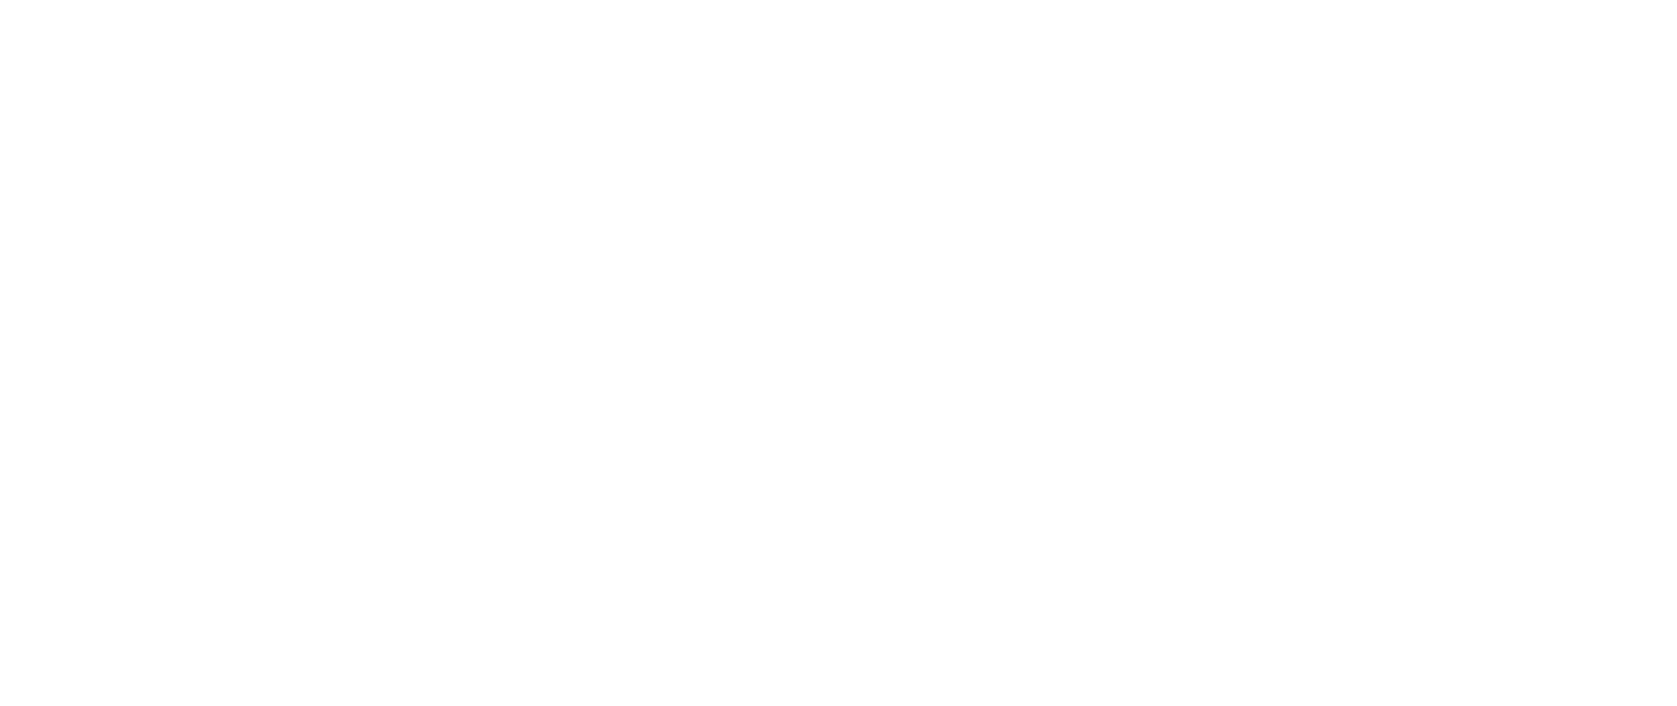

<IPython.core.display.Javascript object>


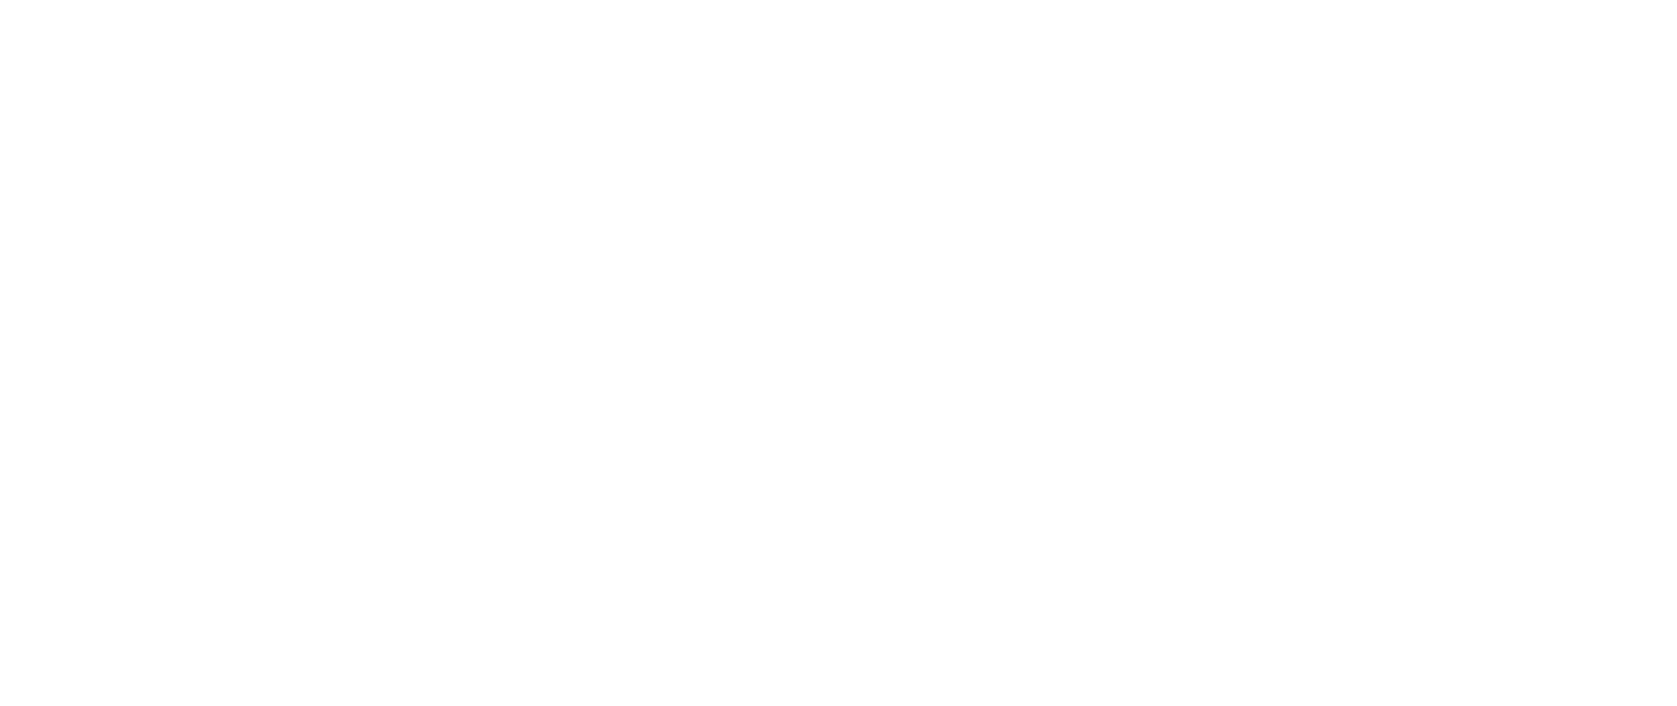

In [9]:
# Code for barrier functions + inequality constraint formulations of obstacle avoidance
%matplotlib inline
from rsbook_code.control.examples.doubleintegrator import DoubleIntegrator
from rsbook_code.control.dynamics import IntegratorControlSpace
from rsbook_code.control.barrier import BarrierPenalty
import copy
from matplotlib import patches

problem = DoubleIntegrator(2)
barrier_strength = 0.1

#Time step is 0.1
dt = 0.05
#20 time steps
N = 20
#number of state / control dimensions
n, m = 4, 2
#Start state is 0
x0 = np.array([0.0]*4)
u0 = np.zeros(2)
#infeasible initial control
#u0 = np.array([2.0,3.0])

#Objective function measures distance to goal + small squared effort penalty + some penalty on final time
P = np.zeros((4,4))
P[0,0] = dt
P[1,1] = dt
Q = np.eye(2)*0.01*dt
R = np.diag([10,10,1,1])
goal = np.array([2.0,3.0,0.0,0.0])

obstacle = CircleObstacle(center=(1.5,2.0),radius=0.75)
#valid barrier types include 'log', 'inv', and 'quadratic'
barrier = BarrierPenalty(obstacle.distance,obstacle.distance_gradient,barriertype='log')
objective = QuadraticObjectiveFunction(P,Q,R,goal) + barrier*barrier_strength

#Guessed trajectory: all 0's
us = [u0 for i in range(N)]
xs,us = rollout_policy(problem,x0,us,dt,N)

ilqr = iLQR(problem,objective,dt)

x = x0
ground_truth_dynamics = IntegratorControlSpace(problem,dt,0.01)  #integrate with timestep 0.01

#run MPC for 20 iterations, reusing last trajectory
ilqr.run(xs,us,10,damping=1e-3)
xs, us = ilqr.xref,ilqr.uref
Nframes = 20

fig, axs = plt.subplots(1, 1, figsize=(5,5))
ax = axs

def update(frame):
    global x,xs,us,goal,obstacles,ax,ilqr
    ax.clear()
    vis_double_integrator(xs,us,goal,[obstacle],ax)
    ax.set_xlim(-1,3)
    ax.set_ylim(-0.5,3.5)
    
    #advance state according to "true" dynamics
    xnext = ground_truth_dynamics.nextState(x,us[0])
    x = xnext
    #read new goal position and update objective function
    goal += np.array([0.0,-0.2,0,0])
    objective.fs[0].goal = goal
    
    #advance u trajectory, read state
    us = np.concatenate((us[1:],[us[-1]]))
    xs = np.concatenate((xs[1:],[xs[-1]]))
    xs[0] = x
    #re-optimize
    ilqr.run(xs,us,10,damping=1e-3)
    xs, us = ilqr.xref,ilqr.uref


# Create the animation
print("MPC, reusing last trajectory")

from rsbook_code.utilities.jupyter_animation import display_animation

framerate = int(1.0/dt)
display_animation(update, Nframes, framerate, fig)

In [10]:
#Now try with diversity from random controls

#reset everything
goal = np.array([2.0,3.0,0.0,0.0])
objective.fs[0].goal = goal 

us = [u0 for i in range(N)]
xs,us = rollout_policy(problem,x0,us,dt,N)

x = x0
ilqr.run(xs,us,10,damping=1e-3)
xs, us = ilqr.xref,ilqr.uref

fig,axs = plt.subplots(1,1,figsize=(5,5))
ax = axs

#run MPC for 8 iterations, using random restart
ilqr.run(xs,us,10,damping=1e-3)
xs, us = ilqr.xref,ilqr.uref
other_trajs = []
def update(frame):
    global x,xs,us,goal,obstacle,objective,ilqr,ax
    global other_trajs
    ax.clear()
    vis_double_integrator(xs,us,goal,[obstacle],ax)
    for traj in other_trajs:
        if traj is not None and traj is not xs:
            ax.plot([q[0] for q in traj],[q[1] for q in traj],color='#ccf',zorder=0)
    ax.set_xlim(-1,3)
    ax.set_ylim(-0.5,3.5)
    
    #advance state according to "true" dynamics
    xnext = ground_truth_dynamics.nextState(x,us[0])
    x = xnext
    #read new goal position
    goal += np.array([0.0,-0.2,0,0])
    objective.fs[0].goal = goal 
    
    #advance u trajectory, read state
    us = np.concatenate((us[1:],[us[-1]]))
    xs = np.concatenate((xs[1:],[xs[-1]]))
    xs[0] = x
    #re-optimize using last controls
    try:
        ilqr.run(xs,us,10,damping=1e-2)
        J_last = ilqr.value[0][0]
        xs_last, us_last = ilqr.xref,ilqr.uref
    except Exception:
        J_last = np.inf
    #optimize using random controls
    us = np.random.uniform(-20.0,20.0,us.shape)
    try:
        ilqr.run(xs,us,10,damping=1e-2)
        J_rand = ilqr.value[0][0]
        xs_rand, us_rand = ilqr.xref,ilqr.uref
    except Exception:
        J_rand = np.inf
        xs_rand = None
    #try braking control
    for j in range(len(us)):
        us[j] = -2.0*xs[j][2:]
        xs[j+1] = ilqr.dynamics.nextState(xs[j],us[j])
    try:
        ilqr.run(xs,us,10,damping=1e-2)
        J_brake = ilqr.value[0][0]
        xs_brake, us_brake = ilqr.xref,ilqr.uref
    except Exception:
        J_brake = np.inf
        xs_brake = None
    print("Cost initializing from last: {}, random: {}, braking: {}".format(J_last,J_rand,J_brake))
    #pick the best
    if J_last < J_rand:
        xs,us = xs_last,us_last
    else:
        xs,us = xs_rand,us_rand
    if J_brake < min(J_rand,J_last):
        xs,us = xs_brake,us_brake
    #store for next display loop
    other_trajs = [xs_last,xs_rand,xs_brake]
    

print("MPC, with diversity")
# Create the animation

from rsbook_code.utilities.jupyter_animation import display_animation

framerate = int(1.0/dt)
display_animation(update, Nframes, framerate, fig)

MPC, with diversity
Cost initializing from last: 5.542501504981404, random: 105.24297306641151, braking: 5.484275652290242
Numerical error: instability is being introduced at timestep 0
X: [0.00700869 0.13079567 0.15070234 2.25919232] U: [0.92902464 0.31592602]
Qxx [[-2.71706620e+303  2.51772018e+304  1.30833610e+302  1.57523539e+304]
 [ 2.51772018e+304 -2.33299981e+305 -1.21234595e+303 -1.45966334e+305]
 [ 1.30833610e+302 -1.21234595e+303 -6.29996925e+300 -7.58515683e+302]
 [ 1.57523539e+304 -1.45966334e+305 -7.58515683e+302 -9.13252141e+304]]
Quu [[-4.14883636e+298 -2.93014110e+300]
 [-2.93014110e+300 -2.06943010e+302]]
K [[-1.06172798e+303  9.83831003e+303  5.11248877e+301  6.15543149e+303]
 [-7.49851890e+304  6.94836674e+305  3.61072652e+303  4.34731121e+305]]
Qxu.dot(K) [[-inf  inf  inf  inf]
 [ inf -inf -inf -inf]
 [ inf -inf -inf -inf]
 [ inf -inf -inf -inf]]
Cost initializing from last: 6.379907066434935, random: 35.512919775692026, braking: inf
Cost initializing from last: 7.5

### Convergence and terminal conditions

Suppose that our original optimal control problem is an infinite horizon one, with objective $J_\infty(x,u) = \int_0^\infty L(x(t),u(t)) dt$.  MPC converts it to a finite horizon problem, $J_T(x,u) = \int_0^T L(x(t),u(t)) dt + \Phi(x(T))$ where we have a choice of terminal cost $\Phi$. We should ask the questions, if the original infinite horizon problem has a stable point $x_0$, will it also be a stable point for MPC?  Will MPC converge to $x_0$ from some starting state $x_c$?  To make the following analysis hold, we assume that MPC indeed computes the finite-horizon optimal trajectory perfectly and that the true dynamics matches the model used by the optimizer.

In general this is a difficult question to answer, but we can state a few things. Let's assume that $L(x,u)\geq 0$ for all $x,u$, and that $L(x_0,u)=0$ for some $u$ satisfying $f(x_0,u)=0$ (indicating that indeed $x_0$ is a stationary point at which cost no longer accumulates).  Then:
- if $\Phi(x)\geq 0$ and $\Phi(x_0)=0$, then $x_0$ is a stable point for MPC.
- if $\Phi(x)$ is a [value function](#Derivation) $V(x)$ for the $J_\infty$ problem, then MPC will converge to $x_0$ from any starting state $x_c$.
- if $\Phi(x)$ is large for any $x \neq x_0$, then MPC will converge to $x_0$ from any starting state $x_c$ that can reach $x_0$ within horizon $T$.

Hence, most strategies for encouraging or ensuring stability are based on the second and third statements to modify the terminal conditions of the optimizer.  If we define an approximation of the infinite-horizon value function, $\Phi(x) \approx V(x)$, then MPC will generally converge quite well across the domain.  Furthermore, if we constrain the terminal state of the MPC optimization problem to be $x(T)=x_0$, then we can ensure convergence as well. The terminal constraint approach can be somewhat relaxed to constrain $x(T)$ to lie within a domain in which MPC is known to stabilize the system, or some alternative stabilizing controller is known to exist.

### Real-time considerations

Because the system timestep $\Delta t$ must be large enough to perform the optimization, the system state can change significantly between the start and the end of computation, and so the control computed by naïve MPC can be inappropriate to use at the new current state $x_c$.  Generally, the larger the timestep, the worse the degradation in performance due to real-time considerations.

**Concurrent execution and optimization.** Instead of interpreting the optimization and execution steps in the pseudocode as sequential, they should be viewed as running concurrently in time.  The execution thread continually reads from $\tilde{x}$ and $\tilde{u}$ and sends the controls to the actuators in real-time. When the MPC thread finishes computing and we say "execute the control", this really means that $\tilde{x}$ and $\tilde{u}$ are updated (atomically) so that the execution thread now reads from the new trajectories.

**Any-time feasible optimization.** When choosing optimization algorithms, *any-time, feasible* methods are preferable. Rather than waiting until the optimizer converges to some numerical tolerance, we wish to halt optimization and take the best answer after $\Delta t$ time has elapsed. A feasible method maintains iterates that are feasible so that the partially-optimized trajectory does not violate constraints regardless of when the optimizer is halted.

Note that as long as the optimization problem does not change too much from step to step, it can be effective to do less optimization work per time step but run optimization more frequently (i.e., shorten the time step).  Essentially, the cost of running an optimizer to convergence is amortized over several time steps, although with slightly different initial conditions. In the extreme, the optimizer can be configured to perform only a single iteration of an inner optimization, a technique called real-time iteration (RTI).

**Next state prediction.** Approximately $\Delta t$ time will pass between the start of optimization and the execution update. During this time, the execution thread will have executed the control $\tilde{u}(t)$ from $t=0$ to $\Delta t$, and the optimizer will have no control over the trajectory being executed.

If we call the range $t\in[0,\Delta t]$ the "immutable region", then the best we can do is control the trajectory after the immutable region passes.  Hence, one approach can be to predict the state at which we will arrive once we finish optimization (e.g., simulating the dynamics with control $\tilde{u}$ up to time $\Delta t$.  Letting $\hat{x}_p$ be the predicted state after the immutable region, we can then optimize starting from $\hat{x}_p$ rather than $x_c$. This typically leads to significantly improved performance for large time steps.

TODO: illustration (Figure 10)

**Gain scheduling.** Gain scheduling is another approach to handling inaccurate predictions. In this approach, the optimizer does not simply compute a reference trajectory $x^{ref},u^{ref}$ but also computes a sequence of gain matrices $K(t)$ such that the control $u(t) = K(t)(x(t)-x^{ref}(t)) +u^{ref}(t)$ uses feedback on the reference tracking error $x(t)-x^{ref}(t)$ to determine the next control.  Methods like DDP and iLQR compute these matrices automatically during their execution, and they provide the optimal control assuming a linearization of the dynamics and a second-order Taylor expansion of the costs about the reference trajectory.  So, rather than having the execution thread execute an open-loop trajectory over the duration $[0,\Delta t]$, it can execute the gain-scheduled policy in closed-loop during the next optimization iteration.



Summary
-------

Key takeaways:

-   Optimal control functions are specified by a dynamics function, a
    cost functional, and optional constraints. By changing the cost
    functional, different performance objectives can be specified.

-   Analytical optimal control techniques can be challenging to apply to
    a given problem, but for some problems can yield computationally
    efficient solutions by greatly reducing the search space.

-   Numerical optimal control techniques are more general, but require
    more computation.

-   In trajectory optimization, time is discretized to produce a
    finite-dimensional optimization problem. There is a tradeoff between
    optimality and speed in the choice of computational grid resolution,
    and are also susceptible to local minima.

-   In Hamilton-Jacobi-Bellman (HJB) techniques, both time and space are
    discretized. There are no local minima, but the technique suffers
    from the curse of dimensionality.

-   Model predictive control (MPC) turns open-loop trajectory
    optimization into a closed-loop controller by means of repeated
    replanning.

The [following table](#tab:OptControlSummary) lists an overview of the approaches
covered in this chapter.

********************************************************************

<div class="figcaption"><a name="tab:OptControlSummary">Summary of optimal control approaches</a></div>

| **Approach**      | **Type**   | **Characteristics** |
|:------------------|:------------:|:-----------------------------------------------------------------------|
| LQR               |Analytical  |Applies to LTI systems with quadratic costs |
| PMP               |Analytical  |Defines necessary conditions for optimality |
| Trajectory opt.   |Numerical   |Optimize a time-discretized control or trajectory space. Susceptible to local minima |
|  - Shooting       |Numerical   |Optimizes over discrete controls |
|  - Direct trans.  |Numerical   |Constrained optimization over discrete controls and states |
|  - Pseudospectral |Numerical   |Constrained optimization over parameterized controls and states |
|  - Indirect       |Numerical   |Optimizes via shooting over initial costate only |
| HJB               |Numerical   |Discretize and solve over state space |
| MPC               |Numerical   |Closed-loop control by repeated optimization |

********************************************************************


Exercises
---------

1.  Consider devising an optimal control formulation that describes how
    your arm should reach for a cup. What is the state $x$? The control
    $u$? The dynamics $f(x,u)$? The objective functional? Is an
    infinite-horizon or finite-horizon more appropriate for this
    problem? Do the same for the task of balancing on one foot.

2.  Recall the point mass double-integrator system:
    $$\dot{x} \equiv \begin{bmatrix}{\dot{p}}\\{\dot{v}}\end{bmatrix} = f(x,u) = \begin{bmatrix}{v}\\{u/M}\end{bmatrix}.$$
    Express this as an LTI system, and solve for the LQR gain matrix $K$
    with the cost terms $Q=\begin{bmatrix}{10}&{0}\\{0}&{1}\end{bmatrix}$ and $R=5$.

3. Let $V^*(x)$ denote the infinite-horizon value function (i.e., the cost incurred by the optimal infinite-horizon control starting at $x$).  Now define a finite-horizon optimal control problem with horizon $T$, the same incremental cost $L$, and terminal cost $\Phi(x) = V^*(x)$. Prove that the solution to this finite-horizon optimal control problem is identical to the infinite horizon optimal control problem for all $x$.

4. Let $V^*_T(x)$ denote the $T$-horizon value function for a terminal cost function $\Phi$.  Suppose that $0 \leq T_1 < T_2$. Is it always true that $V^*_{T2}(x) \geq V^*_{T1}(x)$?  If so, give a proof. If not, define a condition on $\Phi$ that would make this condition true.

5.  **(Programming)** Examine the code example of barrier function obstacle avoidance in Section 4.6.3 (you must open this notebook in Jupyter).  There are several parameters regarding the barrier function, including the strength, barrier type, and barrier distance (for inverse and half-quadratic barriers).  Find where these parameters are implemented in the code and examine the effect of .  Also, examine what happens when you choose the initial trajectory to have constant control $u=(2,3)$. Explain why the optimizer is unable to find a solution with some barrier types.


